In [11]:
from IPython import get_ipython
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1239]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os
os.environ['HF_HOME'] = '/raid/xd/.cache/torch'
from types import MethodType
from tqdm import tqdm
from collections import defaultdict, OrderedDict, Counter, namedtuple
from datetime import datetime
from io import StringIO
from itertools import chain
import math
from functools import reduce, partial
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss
import torch.nn.functional as F 
from torch.utils.data.sampler import RandomSampler, Sampler, SequentialSampler
from torch.utils.data.dataloader import DataLoader

# sys.path.insert(0, '/nas/xd/projects/transformers/src')
from transformers.data.data_collator import DataCollator, default_data_collator
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer, pipeline
from transformers import RobertaForMaskedLM, RobertaTokenizer, GPT2LMHeadModel, GPT2Tokenizer, GPTNeoForCausalLM
from transformers import T5Tokenizer, T5ForConditionalGeneration

from transformers.models.gpt2.modeling_gpt2 import GPT2Attention
from transformers.models.gpt_neo.modeling_gpt_neo import GPTNeoSelfAttention
from transformers.models.gptj.modeling_gptj import GPTJAttention, GPTJBlock
from transformers.models.xglm.modeling_xglm import XGLMAttention

from transformers import HfArgumentParser, Trainer, TrainingArguments, set_seed
# from transformers.trainer_utils import EvaluationStrategy

In [13]:
import einops
from einops import rearrange

In [14]:
# from child_utils import *
from common_utils import *
from child_tasks import *
from model_utils import *

In [16]:
models = {}
cache_dir = '/nas/xd/.cache/torch/transformers/'  # for models besides t5-3b/11b
proxies = {'http': '192.168.50.1:1081'} 

In [654]:
# model_name = "EleutherAI/gpt-neo-1.3B"
for model_name in ['gpt2-large', 
            'gpt2-xl', 'EleutherAI/gpt-neo-1.3B',  # = babbage
            'EleutherAI/gpt-j-6B', 'KoboldAI/fairseq-dense-6.7B', # = curie 
            'KoboldAI/fairseq-dense-13B']:
    if model_name not in models:
        with Timer(model_name):
            model = AutoModelForCausalLM.from_pretrained(model_name, cache_dir=cache_dir)  
            tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=cache_dir)
            models[model_name] = model, tokenizer

gpt2-xl ... done 0:02:54
EleutherAI/gpt-neo-1.3B ... 

Downloading:   0%|          | 0.00/200 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

done 0:02:21
EleutherAI/gpt-j-6B ... done 0:09:32
KoboldAI/fairseq-dense-6.7B ... done 0:05:13
KoboldAI/fairseq-dense-13B ... 

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

done 0:09:43


In [1371]:
# model_name = 'gpt2-large'  # medium / large /xl
model_name = 'EleutherAI/gpt-j-6B' # gpt-j-6B, gpt-neo-1.3B/2.7B
model, tokenizer = models[model_name]
_ = model.eval()

masked_lm = tokenizer.mask_token is not None and len(tokenizer.additional_special_tokens) == 0
if masked_lm:
    mask_token = tokenizer.mask_token  # '<mask>' for roberta
elif len(tokenizer.additional_special_tokens) > 0:
    mask_token = tokenizer.additional_special_tokens[0]  # '<extra_id_0>' for t5
else:
    mask_token = ''  # for gpt2
if masked_lm: nlp = pipeline('fill-mask', model=model, tokenizer=tokenizer, top_k=5)

Using mask_token, but it is not set yet.


In [1252]:
models.keys()

dict_keys(['gpt2-large', 'gpt2-xl', 'EleutherAI/gpt-neo-1.3B', 'EleutherAI/gpt-j-6B', 'KoboldAI/fairseq-dense-6.7B', 'KoboldAI/fairseq-dense-13B', 'text-babbage-001', 'text-curie-001', 'text-davinci-001', 'text-davinci-002'])

In [1372]:
unify(model)
blocks = model.transformer.h
attn = blocks[0].attn
L, H, embed_dim = len(blocks), attn.num_heads, attn.embed_dim

we = model.transformer.wte.weight.t()
# wp = model.transformer.wpe.weight.t()
wu = model.lm_head.weight

In [17]:
# k, n = 5, 4
# bos_id, eos_id = tokenizer._convert_token_to_id('Ġ->'), tokenizer._convert_token_to_id('Ċ')
# l = [bos_id] + choices(range(1, tokenizer.vocab_size-1), k=k) + [eos_id]
# text = tokenizer.decode(l * n)
# examples = text.strip().split('\n')
# print(text)

 -> Lawyers round Wyratesitors
 -> Lawyers round Wyratesitors
 -> Lawyers round Wyratesitors
 -> Lawyers round Wyratesitors



In [1241]:
def forward(model, inputs, labels=None, loss_reduction='None', by_head=False, attribute_layer=None, 
            head_mask=None, mlp_mask=None, attn_weights=None,
            hidden_states=None, detach_layer=None, 
            separate_qkv_layer=None, get_hqkv=None):
    head_mask = fill_list(head_mask, L, attribute_layer)
    mlp_mask = fill_list(mlp_mask, L, attribute_layer)
    attn_weights = fill_list(attn_weights, L, attribute_layer)
    # get_hqkv_fns = fill_list(get_hqkv, L, separate_qkv_layer, default_get_hqkv)
    from_layer = attribute_layer if hidden_states is not None else None

    self = model.transformer
    (hidden_states, inputs_embeds, position_embeds) = embed_forward(self, inputs) \
        if from_layer is None else (hidden_states, None, None)
    all_hidden_states, intermediates, mlp_outputs = (), (), ()
    attn_forward_outputs = []
    for i, b in enumerate(self.h):
        if from_layer is not None and i < from_layer: continue
        if i == detach_layer: hidden_states = hidden_states.detach()
        all_hidden_states += (hidden_states,)
        # hq, hk, hv = get_hqkv_fns[i](hidden_states)
        hq = hk = hv = b.ln_1(hidden_states)
        attn_forward_output = attn_forward(b, hq, hk, hv, by_head=by_head,
                                    head_mask=head_mask[i], attn_weights=attn_weights[i])
        attn_forward_outputs.append(attn_forward_output)
        if not my_isinstance(b, GPTJBlock): hidden_states = hidden_states + attn_forward_output[0]
        mlp_output, intermediate = mlp_forward(b, hidden_states, output_intermediate=True)
        if mlp_mask[i] is not None: mlp_output = einsum('bie,bi->bie', mlp_output, mlp_mask[i])
        intermediates += (intermediate,)
        mlp_outputs += (mlp_output,)
        if my_isinstance(b, GPTJBlock): hidden_states = hidden_states + attn_forward_output[0]
        hidden_states = hidden_states + mlp_output
    attn_outputs, all_attentions, head_inputs, head_outputs = zip(*attn_forward_outputs)
    all_hidden_states += (hidden_states,) # both before and after ln_f
    hidden_states = self.ln_f(hidden_states)
    all_hidden_states += (hidden_states,)

    logits = model.lm_head(hidden_states)
    loss = compute_loss(logits, labels, reduction=loss_reduction) if labels is not None else None
    return Outputs(
        inputs_embeds=inputs_embeds, position_embeds=position_embeds,
        attn_outputs=attn_outputs, head_inputs=head_inputs, head_outputs=head_outputs, 
        intermediates=intermediates, mlp_outputs=mlp_outputs,
        hidden_states=all_hidden_states, attentions=all_attentions, 
        logits=logits, loss=loss,
    )

In [1]:
# nrows, ncols = 2, 3
# text, examples = make_input_str(tasks[0], nrows=nrows, ncols=ncols)
text = "\u003CInduction example. Goobledegook. Goobledegook"  # from unseal
bos_token, eos_token = '.', None
examples = text.split(bos_token)[1:]
k_shot = 1
print(text)
inputs = tokenizer.encode_plus(text, return_tensors='pt')
inputs = prepare_inputs(inputs, model.device)
input_ids = inputs.input_ids
qlen = input_ids.size(1)
# tokenize without tokenization artifact -> needed for visualization, from unseal
tokens = tokenizer.tokenize(text)
tokens = list(map(tokenizer.convert_tokens_to_string, map(lambda x: [x], tokens))) 

<Induction example. Goobledegook. Goobledegook


NameError: name 'tokenizer' is not defined

In [1610]:
# bos_indices, eos_indices, answers, labels = locate_answers(input_ids, tokenizer, bos_token=bos_token, eos_token=eos_token)
# labels[:, :bos_indices[k_shot]] = -100
# with torch.no_grad(): o0 = model(**inputs, output_attentions=True, output_hidden_states=True)
# with torch.no_grad(): o = forward(model, inputs, labels=labels, by_head=True)
with torch.no_grad(): so = sum_forward(model, o, labels=labels, ln_scale=0.2)

in compute_loss, labels = tensor([[ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,   471,  -100,  -100,  -100,  2795,  -100,  -100,
          -100,   367,  -100,  -100,  -100,   642,  -100,  -100,  -100,   474,
          -100,  -100,  -100,  2237,  -100,  -100,  -100,  3269,  -100,  -100,
          -100,  3431,  -100,  -100,  -100,  1395,  -100,  -100,  -100,  -100,
         11695,  -100,  -100,  -100,  2124,  -100,  -100,  -100,  1218,  -100,
          -100,  -100,   604,  -100,  -100]])
in compute_loss, before loss = tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 2.9023, 0.0000, 0.0000, 0.0000, 1.9657,
         0.0000, 0.0000, 0.0000, 3.6207, 0.0000, 0.0000, 0.0000, 0.5844, 0.0000,
         0.0000, 0.0000, 1.6149, 0.0000, 0.0000, 0.0000, 0.7329, 0.0000, 0.0000,
         0.0000, 0.1959, 0.0000, 0.0000, 0.0000, 0.1527, 0.0000, 0.0000, 0.0000,
         1.0816, 0

In [1611]:
loss, _ = show_predictions(text, examples, tokenizer, so.logits, bos_indices, eos_indices, answers, labels, 
                mask_logits_fn=None, topk=3, loss_reduction='mean', show_range=range(k_shot, len(examples)), sep='\t')
print(loss)

  U 0.055 {' A': 0.124, ' W': 0.106, ' N': 0.071} 	 V -> U
  June 0.14 {' August': 0.747, ' June': 0.14, ' September': 0.039} 	 July -> June
  H 0.027 {' O': 0.428, ' J': 0.071, ' E': 0.053} 	 I -> H
* 5 0.557 {' 5': 0.557, ' 7': 0.089, ' 4': 0.074} 	 6 -> 5
* j 0.199 {' j': 0.199, ' h': 0.158, ' g': 0.079} 	 k -> j
* six 0.481 {' six': 0.481, ' eight': 0.267, ' seven': 0.039} 	 seven -> six
* January 0.822 {' January': 0.822, ' March': 0.087, ' February': 0.037} 	 February -> January
* Tuesday 0.858 {' Tuesday': 0.858, ' Thursday': 0.113, ' Monday': 0.012} 	 Wednesday -> Tuesday
* X 0.339 {' X': 0.339, ' N': 0.138, ' Z': 0.084} 	 Y -> X
* sixth 0.852 {' sixth': 0.852, ' six': 0.064, ' eighth': 0.032} 	 seventh -> sixth
* x 0.965 {' x': 0.965, ' z': 0.01, ' X': 0.007} 	 y -> x
* second 0.886 {' second': 0.886, ' first': 0.091, ' fourth': 0.005} 	 third -> second
* 4 0.865 {' 4': 0.865, ' 3': 0.055, ' 1': 0.037} 	 5 -> 4
tensor(1.0241)


In [1524]:
layer_out = L
ln_f = model.transformer.ln_f
for i in range(0, L + 1):
    h = o.hidden_states[i]
    # h = h + attn_forward(blocks[-2], h, h, h)[0]
    # h = h + mlp_forward(blocks[-2], h)
    # h = h + attn_forward(blocks[-1], h, h, h)[0]
    # h = h + mlp_forward(blocks[-1], h)
    # h = ln_f(h)
    # logits = model.lm_head(ln_f(h))
    # print(i)
    # _, all_top1_correct = show_predictions(text, examples, tokenizer, logits, bos_indices, eos_indices, answers, labels, 
    #             mask_logits_fn=None, topk=5, show_range=range(k_shot, len(examples)), sep='\t')

    logits = model.lm_head(ln_f(h + o.attn_outputs[i]))
    print(i, 'after attn')
    _, all_top1_correct = show_predictions(text, examples, tokenizer, logits, bos_indices, eos_indices, answers, labels, 
                mask_logits_fn=None, topk=5, show_range=range(k_shot, len(examples)), sep='\t')
    logits = model.lm_head(ln_f(h + o.attn_outputs[i] + o.mlp_outputs[i]))
    print(i, 'after mlp')
    _, all_top1_correct = show_predictions(text, examples, tokenizer, logits, bos_indices, eos_indices, answers, labels, 
                mask_logits_fn=None, topk=5, show_range=range(k_shot, len(examples)), sep='\t')
    if all_top1_correct and layer_out == L: layer_out = i
print(layer_out)

0 after attn
  L 0.0 {' odd': 0.021, ' electronically': 0.015, 'ether': 0.013, ' scientifically': 0.011, ' easy': 0.011} 	 M -> L
  U 0.0 {'ether': 0.018, ' easy': 0.013, 'fork': 0.013, ' discover': 0.012, ' CR': 0.012} 	 V -> U
  June 0.0 {'ether': 0.03, ' prep': 0.024, ' discover': 0.021, ' declared': 0.015, ' weekly': 0.015} 	 July -> June
  H 0.0 {' prep': 0.049, ' discover': 0.026, 'ether': 0.017, ' naturally': 0.014, ' easy': 0.013} 	 I -> H
  5 0.0 {'ether': 0.158, 'fork': 0.019, 'ints': 0.017, ' CR': 0.012, 'defined': 0.009} 	 6 -> 5
  j 0.0 {'ether': 0.112, ' CR': 0.018, 'fork': 0.015, 'defined': 0.014, ' prep': 0.014} 	 k -> j
  six 0.0 {'ether': 0.112, 'oner': 0.009, 'fork': 0.008, ' Virgin': 0.008, 'ories': 0.007} 	 seven -> six
  January 0.0 {' easy': 0.055, 'oner': 0.031, ' prep': 0.03, ' subtract': 0.021, ' CR': 0.013} 	 February -> January
  Tuesday 0.0 {' prep': 0.071, ' CR': 0.044, 'oner': 0.03, ' easy': 0.026, ' subtract': 0.023} 	 Wednesday -> Tuesday
  X 0.0 {' pre

IndexError: tuple index out of range

In [1637]:
for l, h, v in zip(*topk_md(head_attr, 20)):
    print(l, h, v)
    logits = model.lm_head(ln_f(o.head_outputs[l][:, h]))
    show_predictions(text, examples, tokenizer, logits, bos_indices, eos_indices, answers, labels, 
                mask_logits_fn=None, topk=5, show_range=range(k_shot, len(examples)), sep='\t')

18 3 0.7604537
  U 0.0 {' C': 0.831, ' N': 0.066, ' M': 0.03, ' Q': 0.014, ' B': 0.01} 	 V -> U
  June 0.002 {' July': 0.373, ' October': 0.166, ' September': 0.159, ' November': 0.094, ' February': 0.086} 	 July -> June
  H 0.0 {' July': 0.35, ' September': 0.144, ' October': 0.141, ' February': 0.118, ' January': 0.11} 	 I -> H
  5 0.0 {' 6': 0.995, ' 7': 0.003, '6': 0.001, '7': 0.0, ' 5': 0.0} 	 6 -> 5
  j 0.0 {' 6': 0.84, ' 5': 0.157, ' 7': 0.003, ' 4': 0.0, '6': 0.0} 	 k -> j
  six 0.001 {' seven': 0.991, ' eight': 0.006, 'seven': 0.002, ' six': 0.001, ' nine': 0.0} 	 seven -> six
  January 0.001 {' seven': 0.834, ' six': 0.055, ' February': 0.045, ' July': 0.035, ' eight': 0.016} 	 February -> January
  Tuesday 0.006 {'Wednesday': 0.585, ' Wednesday': 0.231, 'Thursday': 0.107, ' Thursday': 0.045, 'Tuesday': 0.024} 	 Wednesday -> Tuesday
  X 0.0 {' July': 0.209, ' February': 0.185, 'Wednesday': 0.1, 'Thursday': 0.079, ' January': 0.064} 	 Y -> X
  sixth 0.002 {' seventh': 0.974, '

(tensor(20.1947, grad_fn=<NllLossBackward>), False)

13 9 0.6324224
  U 0.0 {'L': 0.293, 'M': 0.098, 'P': 0.097, 'J': 0.085, 'K': 0.067} 	 V -> U
  June 0.001 {'May': 0.935, ' May': 0.052, 'June': 0.012, ' June': 0.001, 'April': 0.0} 	 July -> June
  H 0.0 {'I': 0.997, 'E': 0.001, 'A': 0.001, 'H': 0.0, 'M': 0.0} 	 I -> H
  5 0.0 {'5': 0.995, '4': 0.005, ' 5': 0.0, ' 4': 0.0, '3': 0.0} 	 6 -> 5
  j 0.0 {'k': 0.995, '5': 0.002, 'j': 0.002, 'x': 0.001, 'five': 0.0} 	 k -> j
  six 0.0 {'six': 0.821, 'five': 0.172, 'four': 0.006, '6': 0.0, ' six': 0.0} 	 seven -> six
  January 0.015 {'January': 0.601, 'Christmas': 0.137, ' Christmas': 0.116, 'December': 0.106, ' January': 0.015} 	 February -> January
  Tuesday 0.003 {'Tuesday': 0.996, ' Tuesday': 0.003, 'Monday': 0.0, ' Monday': 0.0, ' Tues': 0.0} 	 Wednesday -> Tuesday
  X 0.0 {'Y': 0.452, 'X': 0.249, 'H': 0.052, 'E': 0.043, 'M': 0.042} 	 Y -> X
  sixth 0.0 {'five': 0.833, 'six': 0.164, 'four': 0.002, ' Five': 0.0, ' five': 0.0} 	 seventh -> sixth
  x 0.0 {'x': 0.81, 'y': 0.19, 'n': 0.0, 'w'

(tensor(17.7317, grad_fn=<NllLossBackward>), False)

24 10 0.47890106
  U 0.0 {' V': 0.999, 'V': 0.001, ' N': 0.0, ' M': 0.0, ' W': 0.0} 	 V -> U
  June 0.038 {' August': 0.735, 'August': 0.213, ' June': 0.038, ' Aug': 0.008, 'June': 0.003} 	 July -> June
  H 0.0 {' O': 0.99, ' J': 0.006, ' U': 0.003, ' Z': 0.0, ' K': 0.0} 	 I -> H
* 5 0.867 {' 5': 0.867, '5': 0.105, ' O': 0.02, ' 4': 0.005, ' 8': 0.002} 	 6 -> 5
  j 0.118 {' 9': 0.364, ' h': 0.256, ' J': 0.145, ' j': 0.118, ' q': 0.026} 	 k -> j
  six 0.001 {' 6': 0.609, '6': 0.275, ' 8': 0.074, '8': 0.04, ' six': 0.001} 	 seven -> six
* January 0.848 {' January': 0.848, 'January': 0.131, '2001': 0.009, ' 2001': 0.006, ' March': 0.003} 	 February -> January
* Tuesday 0.541 {' Tuesday': 0.541, 'Tuesday': 0.452, '1997': 0.003, ' Tues': 0.001, ' 1997': 0.001} 	 Wednesday -> Tuesday
  X 0.0 {' Z': 0.965, ' Zhu': 0.013, 'Z': 0.011, ' KM': 0.002, ' M': 0.002} 	 Y -> X
* sixth 0.523 {' sixth': 0.523, ' Sixth': 0.234, '6': 0.106, ' 6': 0.075, 'six': 0.036} 	 seventh -> sixth
  x 0.0 {' Z': 0.32

(tensor(6.0542, grad_fn=<NllLossBackward>), False)

13 13 0.3682408
  U 0.0 {' M': 0.176, ' Q': 0.127, ' C': 0.071, ' Y': 0.066, ' W': 0.049} 	 V -> U
  June 0.012 {' July': 0.23, ' September': 0.189, ' February': 0.174, ' November': 0.123, ' December': 0.09} 	 July -> June
  H 0.0 {'II': 0.229, 'III': 0.178, 'VI': 0.072, 'Q': 0.052, 'Fi': 0.033} 	 I -> H
  5 0.002 {' 47': 0.126, ' 44': 0.062, ' 46': 0.056, ' 62': 0.05, ' 52': 0.038} 	 6 -> 5
  j 0.0 {'q': 0.199, 'nr': 0.113, 'jl': 0.049, 'dn': 0.036, 'mi': 0.035} 	 k -> j
  six 0.001 {' forty': 0.232, ' seventy': 0.091, ' thirty': 0.09, ' nineteen': 0.073, ' eighty': 0.072} 	 seven -> six
  January 0.092 {' July': 0.153, ' February': 0.123, ' January': 0.092, 'January': 0.079, 'September': 0.078} 	 February -> January
  Tuesday 0.046 {' Sunday': 0.199, ' Saturday': 0.128, ' Friday': 0.063, ' July': 0.061, ' Tuesday': 0.046} 	 Wednesday -> Tuesday
  X 0.007 {'Q': 0.341, ' Y': 0.199, ' M': 0.055, ' Q': 0.043, 'Y': 0.041} 	 Y -> X
  sixth 0.095 {' seventh': 0.326, ' ninth': 0.209, ' eight

(tensor(6.4308, grad_fn=<NllLossBackward>), False)

9 2 0.36678928
  U 0.0 {'V': 0.237, 'VI': 0.203, 'VS': 0.106, 'LV': 0.095, 'NV': 0.072} 	 V -> U
  June 0.004 {' October': 0.266, ' September': 0.212, ' December': 0.16, ' July': 0.113, ' August': 0.057} 	 July -> June
  H 0.0 {'II': 0.52, ' II': 0.28, 'ii': 0.16, 'III': 0.013, ' III': 0.01} 	 I -> H
  5 0.004 {' 7': 0.932, ' 6': 0.038, ' 8': 0.013, ' 9': 0.006, ' 5': 0.004} 	 6 -> 5
  j 0.0 {'k': 0.683, ' k': 0.127, ' km': 0.034, 'kt': 0.03, 'aks': 0.01} 	 k -> j
  six 0.005 {' eleven': 0.258, ' eight': 0.188, ' twelve': 0.148, ' eighth': 0.077, ' thirteen': 0.047} 	 seven -> six
  January 0.015 {' March': 0.552, ' February': 0.173, ' April': 0.107, ' October': 0.04, ' July': 0.021} 	 February -> January
  Tuesday 0.005 {' Thursday': 0.405, ' Sunday': 0.175, ' weekday': 0.133, ' Saturday': 0.046, ' Wednesday': 0.041} 	 Wednesday -> Tuesday
  X 0.015 {'Y': 0.748, ' Y': 0.075, 'X': 0.061, 'Z': 0.046, 'nz': 0.018} 	 Y -> X
  sixth 0.061 {' tenth': 0.414, ' eighth': 0.334, ' ninth': 0.147

(tensor(6.6052, grad_fn=<NllLossBackward>), False)

17 10 0.34165576
  U 0.0 {' Friday': 0.491, ' Sunday': 0.223, ' Saturday': 0.064, ' Five': 0.039, ' week': 0.027} 	 V -> U
  June 0.0 {' month': 0.957, ' July': 0.031, 'month': 0.009, ' Month': 0.002, 'July': 0.001} 	 July -> June
  H 0.0 {' month': 0.718, 'month': 0.175, ' Month': 0.077, 'Month': 0.029, ' July': 0.0} 	 I -> H
  5 0.0 {' six': 0.895, ' 6': 0.039, ' Six': 0.037, 'six': 0.024, 'Six': 0.005} 	 6 -> 5
  j 0.0 {' 6': 0.491, ' six': 0.405, ' 6000': 0.071, ' sixth': 0.019, ' Six': 0.005} 	 k -> j
  six 0.0 {' seven': 0.993, ' Seven': 0.003, 'seven': 0.003, 'Seven': 0.002, ' seventh': 0.0} 	 seven -> six
  January 0.0 {' February': 0.772, ' month': 0.186, 'month': 0.017, 'February': 0.016, ' Month': 0.006} 	 February -> January
  Tuesday 0.0 {'Wednesday': 0.608, ' Wednesday': 0.392, ' Thursday': 0.0, 'Thursday': 0.0, 'Tuesday': 0.0} 	 Wednesday -> Tuesday
  X 0.0 {' year': 0.785, ' Year': 0.191, 'Year': 0.014, 'year': 0.009, ' annual': 0.001} 	 Y -> X
  sixth 0.0 {' seventh': 

(tensor(23.5731, grad_fn=<NllLossBackward>), False)

14 7 0.26623338
  U 0.0 {' Volume': 0.275, ' volume': 0.183, 'volume': 0.177, 'Volume': 0.134, ' volumes': 0.109} 	 V -> U
  June 0.0 {' month': 0.768, ' date': 0.142, ' dates': 0.061, ' Month': 0.018, 'date': 0.005} 	 July -> June
  H 0.0 {'Type': 0.231, ' indices': 0.134, ' index': 0.132, ' type': 0.096, ' indexes': 0.073} 	 I -> H
  5 0.0 {' number': 0.602, ' numbers': 0.188, 'number': 0.1, ' Number': 0.077, 'Number': 0.032} 	 6 -> 5
  j 0.0 {' sizes': 0.229, ' size': 0.185, ' number': 0.154, 'size': 0.092, 'number': 0.085} 	 k -> j
  six 0.0 {' number': 0.665, 'number': 0.303, ' Number': 0.019, 'Number': 0.009, ' numbers': 0.004} 	 seven -> six
  January 0.0 {' date': 0.768, 'date': 0.089, ' dates': 0.071, ' month': 0.045, ' Date': 0.01} 	 February -> January
  Tuesday 0.0 {' days': 0.459, ' weekday': 0.381, 'days': 0.046, ' day': 0.035, 'day': 0.024} 	 Wednesday -> Tuesday
  X 0.0 {' Year': 0.544, ' year': 0.152, 'Year': 0.114, 'year': 0.056, ' Dates': 0.043} 	 Y -> X
  sixth 0.0 

(tensor(17.3477, grad_fn=<NllLossBackward>), False)

25 8 0.25237942
  U 0.0 {' R': 0.471, ' W': 0.269, ' D': 0.104, ' H': 0.036, ' N': 0.028} 	 V -> U
  June 0.046 {' May': 0.328, ' November': 0.148, ' December': 0.132, ' February': 0.095, ' October': 0.071} 	 July -> June
  H 0.0 {'II': 0.794, ' II': 0.206, ' III': 0.0, 'III': 0.0, ' ii': 0.0} 	 I -> H
  5 0.013 {' 2': 0.776, ' 4': 0.095, ' 3': 0.094, ' 5': 0.013, ' 9': 0.008} 	 6 -> 5
  j 0.0 {' v': 0.978, 'v': 0.007, ' 2': 0.003, ' V': 0.002, 'ii': 0.001} 	 k -> j
  six 0.0 {' v': 0.477, '2': 0.211, 'v': 0.153, '3': 0.021, ' 2': 0.018} 	 seven -> six
  January 0.0 {' twenty': 0.178, ' nineteen': 0.147, ' seventy': 0.134, ' seventeen': 0.12, ' eighteen': 0.078} 	 February -> January
  Tuesday 0.0 {' seventeen': 0.244, ' nineteen': 0.217, ' eighteen': 0.111, ' sixty': 0.075, ' twenty': 0.074} 	 Wednesday -> Tuesday
* X 0.763 {' X': 0.763, 'X': 0.237, ' x': 0.0, 'x': 0.0, 'Z': 0.0} 	 Y -> X
  sixth 0.0 {' nineteen': 0.203, ' sixteen': 0.202, ' eighteen': 0.195, ' seventeen': 0.137, ' th

(tensor(12.5333, grad_fn=<NllLossBackward>), False)

16 14 0.22677983
  U 0.0 {' horizontal': 0.675, ' horizont': 0.11, ' un': 0.102, ' flat': 0.031, ' human': 0.009} 	 V -> U
  June 0.0 {' winter': 0.743, ' Winter': 0.186, 'winter': 0.04, 'Winter': 0.02, ' winters': 0.009} 	 July -> June
  H 0.0 {' exterior': 0.21, 'male': 0.145, ' externally': 0.067, ' external': 0.053, 'Male': 0.048} 	 I -> H
  5 0.002 {' 1': 0.479, ' broader': 0.1, ' continuum': 0.037, ' other': 0.033, ' wider': 0.03} 	 6 -> 5
  j 0.0 {' full': 0.474, 'full': 0.381, ' Full': 0.036, ' regular': 0.022, 'regular': 0.01} 	 k -> j
  six 0.0 {' 1': 0.092, 'single': 0.089, ' singles': 0.048, ' single': 0.047, ' open': 0.043} 	 seven -> six
  January 0.015 {' summer': 0.422, ' autumn': 0.068, ' October': 0.029, ' third': 0.024, ' warmer': 0.019} 	 February -> January
  Tuesday 0.001 {' weekend': 0.172, ' weekends': 0.105, ' un': 0.075, ' Mondays': 0.07, ' unilateral': 0.066} 	 Wednesday -> Tuesday
  X 0.465 {'X': 0.512, ' X': 0.465, ' x': 0.017, 'x': 0.005, 'xs': 0.0} 	 Y ->

(tensor(7.4763, grad_fn=<NllLossBackward>), False)

18 9 0.21567228
  U 0.0 {' Mondays': 0.353, ' Week': 0.168, ' hour': 0.089, ' Month': 0.06, ' weekends': 0.057} 	 V -> U
  June 0.0 {' Month': 0.629, ' month': 0.197, ' Week': 0.126, 'month': 0.021, ' week': 0.008} 	 July -> June
  H 0.0 {' Month': 0.808, ' Week': 0.128, ' month': 0.033, 'month': 0.009, ' Mondays': 0.004} 	 I -> H
  5 0.0 {' Month': 0.599, ' Week': 0.147, ' month': 0.13, ' weekends': 0.026, 'month': 0.026} 	 6 -> 5
  j 0.0 {' hour': 0.599, 'hour': 0.133, ' Hours': 0.073, 'hours': 0.027, ' hours': 0.023} 	 k -> j
  six 0.005 {' 7': 0.144, ' 6': 0.09, ' 9': 0.073, ' 8': 0.071, ' Mondays': 0.067} 	 seven -> six
  January 0.004 {' month': 0.632, ' Month': 0.223, 'month': 0.12, ' January': 0.004, ' Week': 0.004} 	 February -> January
  Tuesday 0.051 {'day': 0.427, ' weekday': 0.13, ' Tues': 0.062, ' Tuesday': 0.051, ' Thursday': 0.048} 	 Wednesday -> Tuesday
  X 0.011 {' Month': 0.477, ' Year': 0.108, ' Week': 0.094, 'month': 0.043, ' Mondays': 0.034} 	 Y -> X
* sixth 0.957

(tensor(9.0782, grad_fn=<NllLossBackward>), False)

16 7 0.15815622
  U 0.0 {' 1': 0.063, ' V': 0.027, ' /': 0.022, ' Rud': 0.011, 'XT': 0.011} 	 V -> U
  June 0.0 {' Ult': 0.032, 'XT': 0.013, ' Fant': 0.012, ' Rud': 0.01, ' Ret': 0.008} 	 July -> June
  H 0.0 {' July': 0.705, ' Jul': 0.02, ' VII': 0.019, 'July': 0.019, ' Cla': 0.008} 	 I -> H
  5 0.0 {'XT': 0.012, ' sh': 0.009, ' Fant': 0.008, ' Rud': 0.007, ' Shot': 0.006} 	 6 -> 5
  j 0.0 {'k': 0.427, ' k': 0.406, ' K': 0.12, 'K': 0.015, 'kil': 0.009} 	 k -> j
  six 0.001 {' seven': 0.414, 'seven': 0.232, ' seventh': 0.212, ' 7': 0.086, ' Seven': 0.017} 	 seven -> six
  January 0.05 {' February': 0.167, ' 1': 0.114, ' January': 0.05, ' 2': 0.044, ' Feb': 0.041} 	 February -> January
  Tuesday 0.0 {' 1': 0.514, ' January': 0.433, ' Jan': 0.019, '1': 0.013, 'January': 0.01} 	 Wednesday -> Tuesday
  X 0.002 {' /': 0.028, ' sh': 0.017, ' Sh': 0.014, ' Shot': 0.014, 'itsch': 0.007} 	 Y -> X
* sixth 0.985 {' sixth': 0.985, ' Sixth': 0.007, ' six': 0.005, ' 6': 0.002, 'six': 0.002} 	 sevent

(tensor(9.1035, grad_fn=<NllLossBackward>), False)

24 7 0.15756723
  U 0.0 {' weekend': 0.608, ' Weekend': 0.104, ' week': 0.095, ' afternoon': 0.036, ' Saturday': 0.03} 	 V -> U
  June 0.0 {' week': 0.392, ' month': 0.146, ' date': 0.139, 'date': 0.095, ' Month': 0.078} 	 July -> June
  H 0.0 {' week': 0.54, ' month': 0.238, ' Month': 0.133, ' year': 0.021, 'week': 0.02} 	 I -> H
  5 0.0 {' week': 0.752, ' month': 0.159, ' Month': 0.05, 'week': 0.022, ' weekend': 0.007} 	 6 -> 5
  j 0.0 {' week': 0.435, ' month': 0.345, 'week': 0.071, ' year': 0.062, ' Month': 0.045} 	 k -> j
  six 0.001 {' week': 0.806, ' month': 0.112, ' year': 0.033, 'week': 0.012, ' seven': 0.005} 	 seven -> six
  January 0.0 {' month': 0.839, ' week': 0.087, ' year': 0.009, 'month': 0.008, ' Month': 0.007} 	 February -> January
  Tuesday 0.0 {' week': 0.97, ' day': 0.013, ' weekend': 0.008, 'week': 0.005, ' month': 0.002} 	 Wednesday -> Tuesday
  X 0.0 {' week': 0.65, ' month': 0.263, ' year': 0.05, ' weekend': 0.021, ' weeks': 0.004} 	 Y -> X
  sixth 0.171 {' fi

(tensor(14.5400, grad_fn=<NllLossBackward>), False)

22 7 0.15375999
  U 0.0 {' Today': 0.61, ' today': 0.327, ' TODAY': 0.029, 'Today': 0.018, ' tomorrow': 0.006} 	 V -> U
  June 0.0 {' Today': 0.668, ' today': 0.295, 'Today': 0.017, ' TODAY': 0.008, ' Yesterday': 0.006} 	 July -> June
  H 0.0 {' Today': 0.45, ' today': 0.379, ' Yesterday': 0.058, ' TODAY': 0.043, 'Today': 0.039} 	 I -> H
  5 0.0 {' today': 0.483, ' Today': 0.46, 'Today': 0.023, 'today': 0.02, ' Yesterday': 0.007} 	 6 -> 5
  j 0.0 {' Tomorrow': 0.467, ' Today': 0.155, ' tomorrow': 0.116, ' today': 0.098, ' Yesterday': 0.034} 	 k -> j
  six 0.07 {' five': 0.357, ' four': 0.249, ' eight': 0.096, ' nine': 0.076, ' six': 0.07} 	 seven -> six
  January 0.0 {' eight': 0.138, ' today': 0.135, ' six': 0.113, ' four': 0.108, ' five': 0.095} 	 February -> January
  Tuesday 0.001 {' towards': 0.208, ' Towards': 0.207, ' Today': 0.199, ' today': 0.184, ' TODAY': 0.064} 	 Wednesday -> Tuesday
  X 0.0 {' N': 0.886, 'N': 0.112, ' You': 0.001, 'Until': 0.0, 'You': 0.0} 	 Y -> X
  sixth

(tensor(22.4531, grad_fn=<NllLossBackward>), False)

13 2 0.14248824
  U 0.0 {' Virgin': 0.072, ' Virtual': 0.065, ' Volt': 0.035, ' Voltage': 0.034, ' Vent': 0.032} 	 V -> U
  June 0.017 {' July': 0.642, 'July': 0.063, ' Jul': 0.048, ' 07': 0.032, ' June': 0.017} 	 July -> June
  H 0.0 {' iodine': 0.252, ' International': 0.106, ' IG': 0.052, ' Isa': 0.05, ' Institute': 0.049} 	 I -> H
  5 0.001 {' sixth': 0.288, ' Sixth': 0.133, ' Six': 0.049, 'shaw': 0.033, ' 306': 0.025} 	 6 -> 5
  j 0.0 {' kil': 0.124, ' Kappa': 0.055, 'ksh': 0.041, ' Kob': 0.038, ' Ku': 0.032} 	 k -> j
  six 0.0 {' Seventh': 0.098, '00007': 0.084, ' 07': 0.056, ' 2007': 0.041, ' seventh': 0.032} 	 seven -> six
  January 0.0 {' February': 0.649, 'Feb': 0.129, 'February': 0.054, ' Feb': 0.048, ' 02': 0.037} 	 February -> January
  Tuesday 0.0 {' Wed': 0.206, 'Wednesday': 0.062, ' Williams': 0.051, ' William': 0.045, ' Williamson': 0.034} 	 Wednesday -> Tuesday
  X 0.0 {' Yamaha': 0.369, ' Yao': 0.08, ' Yemen': 0.077, ' Yoshi': 0.043, ' Yamato': 0.039} 	 Y -> X
  sixt

(tensor(10.7979, grad_fn=<NllLossBackward>), False)

17 13 0.14209767
  U 0.0 {' Month': 0.092, ' Volume': 0.043, ' Woman': 0.04, ' Mode': 0.028, ' V': 0.028} 	 V -> U
  June 0.0 {' month': 0.549, ' Month': 0.421, ' calendar': 0.024, ' Year': 0.001, ' holiday': 0.0} 	 July -> June
  H 0.0 {' Index': 0.871, ' index': 0.111, ' Intermediate': 0.005, ' indexes': 0.002, ' Institute': 0.001} 	 I -> H
  5 0.0 {' integers': 0.463, ' integer': 0.183, ' Numbers': 0.149, ' Year': 0.07, ' numbers': 0.028} 	 6 -> 5
  j 0.0 {' integer': 0.62, ' k': 0.156, ' value': 0.038, ' kernel': 0.014, ' integers': 0.011} 	 k -> j
  six 0.001 {' number': 0.284, ' numbers': 0.225, ' integers': 0.112, ' numbered': 0.099, ' Number': 0.082} 	 seven -> six
  January 0.0 {' month': 0.969, ' Month': 0.024, 'month': 0.004, ' months': 0.001, ' seasons': 0.0} 	 February -> January
  Tuesday 0.006 {' days': 0.24, ' day': 0.177, ' Mondays': 0.094, ' weekday': 0.066, ' holiday': 0.064} 	 Wednesday -> Tuesday
  X 0.051 {' Year': 0.746, ' X': 0.051, ' acronym': 0.032, ' Days': 0

(tensor(8.3231, grad_fn=<NllLossBackward>), False)

13 4 0.13716292
  U 0.0 {'wi': 0.072, ' VI': 0.027, 'WI': 0.021, 'w': 0.021, 'VI': 0.019} 	 V -> U
  June 0.0 {' 8': 0.019, ' mothers': 0.01, ' green': 0.008, ' sins': 0.008, ' widow': 0.007} 	 July -> June
  H 0.0 {'II': 0.667, ' II': 0.243, 'j': 0.046, ' j': 0.033, 'ii': 0.004} 	 I -> H
  5 0.0 {' seventh': 0.962, '7': 0.024, ' 7': 0.003, '00007': 0.001, 'VII': 0.001} 	 6 -> 5
  j 0.0 {'hip': 0.048, ' Donald': 0.016, ' Barbie': 0.011, ' Chev': 0.011, ' ner': 0.011} 	 k -> j
  six 0.0 {' eighth': 0.995, '8': 0.001, ' Eighth': 0.001, ' 8': 0.001, ' eighteenth': 0.0} 	 seven -> six
  January 0.0 {'third': 0.463, ' third': 0.352, ' Third': 0.094, 'Third': 0.025, ' thirds': 0.018} 	 February -> January
  Tuesday 0.0 {' Republicans': 0.041, ' 1955': 0.03, ' Thursday': 0.024, ' Thurs': 0.015, ' quiet': 0.014} 	 Wednesday -> Tuesday
  X 0.001 {' z': 0.37, 'Z': 0.269, ' Z': 0.26, 'z': 0.016, 'X': 0.009} 	 Y -> X
  sixth 0.0 {' eighth': 0.982, ' Eighth': 0.013, ' eighteenth': 0.001, '8': 0.001

(tensor(13.7952, grad_fn=<NllLossBackward>), False)

12 10 0.11465125
  U 0.0 {' Lab': 0.138, ' 1': 0.094, ' Less': 0.067, ' Link': 0.063, ' Lt': 0.031} 	 V -> U
  June 0.0 {' 1': 0.046, ' Fri': 0.026, ' Lab': 0.02, ' 6': 0.018, ' 7': 0.017} 	 July -> June
  H 0.0 {' 1': 0.071, ' Lab': 0.044, ' Saras': 0.023, ' Noon': 0.017, ' Less': 0.015} 	 I -> H
  5 0.001 {' Hoy': 0.041, ' Hom': 0.031, ' Ham': 0.02, ' Lab': 0.018, ' Psy': 0.015} 	 6 -> 5
  j 0.0 {' 7': 0.235, ' 6': 0.116, ' 9': 0.094, ' 5': 0.081, ' 31': 0.035} 	 k -> j
  six 0.001 {' Renaissance': 0.028, ' Saras': 0.018, ' Silver': 0.016, ' July': 0.012, ' 7': 0.012} 	 seven -> six
  January 0.03 {' June': 0.13, ' July': 0.062, ' September': 0.033, ' January': 0.03, ' December': 0.028} 	 February -> January
  Tuesday 0.0 {' January': 0.061, ' Renaissance': 0.05, ' Saras': 0.026, ' July': 0.019, ' Silver': 0.016} 	 Wednesday -> Tuesday
  X 0.001 {' 31': 0.031, ' 7': 0.031, ' 410': 0.028, ' 201': 0.016, ' 19': 0.015} 	 Y -> X
  sixth 0.004 {' six': 0.038, ' Renaissance': 0.026, ' twel

(tensor(8.4185, grad_fn=<NllLossBackward>), False)

17 9 0.10134569
  U 0.0 {'V': 0.631, ' letters': 0.152, ' V': 0.145, ' letter': 0.034, ' Vincent': 0.016} 	 V -> U
  June 0.0 {'7': 0.858, ' 7': 0.136, ' Seven': 0.002, ' seventh': 0.001, ' seven': 0.001} 	 July -> June
  H 0.0 {' letters': 0.425, ' letter': 0.364, ' spelling': 0.181, ' Letters': 0.01, ' Letter': 0.009} 	 I -> H
  5 0.0 {'6': 0.52, ' 6': 0.468, ' six': 0.005, ' Sixth': 0.004, ' sixth': 0.003} 	 6 -> 5
  j 0.0 {' keys': 0.35, ' key': 0.331, ' Key': 0.182, 'Key': 0.038, ' Keys': 0.026} 	 k -> j
  six 0.0 {'7': 0.701, ' seven': 0.149, ' Seven': 0.113, 'seven': 0.019, ' 7': 0.012} 	 seven -> six
  January 0.0 {'2': 0.907, ' 2': 0.093, '02': 0.0, ' 02': 0.0, ' II': 0.0} 	 February -> January
  Tuesday 0.0 {' 1': 0.711, '1': 0.288, ' 01': 0.0, '01': 0.0, '001': 0.0} 	 Wednesday -> Tuesday
  X 0.0 {' letters': 0.61, ' letter': 0.228, ' spelling': 0.149, ' alphabet': 0.005, 'letters': 0.003} 	 Y -> X
* sixth 0.31 {' sixth': 0.31, ' six': 0.307, '6': 0.296, 'six': 0.049, ' 6': 

(tensor(25.9625, grad_fn=<NllLossBackward>), False)

15 7 0.096810624
  U 0.0 {' V': 0.959, 'V': 0.041, ' L': 0.0, 'VL': 0.0, 'VI': 0.0} 	 V -> U
  June 0.033 {' July': 0.788, ' May': 0.149, ' June': 0.033, ' April': 0.008, ' August': 0.005} 	 July -> June
  H 0.0 {' May': 0.552, ' July': 0.158, ' I': 0.084, ' II': 0.084, ' June': 0.049} 	 I -> H
  5 0.002 {' 7': 0.465, ' 6': 0.325, ' 8': 0.097, '6': 0.045, '7': 0.039} 	 6 -> 5
  j 0.0 {' K': 0.967, 'k': 0.031, ' k': 0.001, 'K': 0.001, 'kn': 0.0} 	 k -> j
  six 0.0 {' Seven': 0.626, 'seven': 0.169, ' Eleven': 0.036, 'nine': 0.033, ' eleven': 0.025} 	 seven -> six
  January 0.02 {' May': 0.348, ' July': 0.239, ' June': 0.131, ' February': 0.084, ' April': 0.068} 	 February -> January
  Tuesday 0.001 {' February': 0.25, ' January': 0.186, ' September': 0.173, ' July': 0.104, ' June': 0.063} 	 Wednesday -> Tuesday
  X 0.001 {' Y': 0.999, ' X': 0.001, ' J': 0.0, 'Y': 0.0, ' H': 0.0} 	 Y -> X
  sixth 0.009 {' Seventh': 0.507, ' eighth': 0.241, ' seventh': 0.126, ' Eighth': 0.029, ' Sixth': 0.

(tensor(10.9988, grad_fn=<NllLossBackward>), False)

26 14 0.09662059
  U 0.0 {' normal': 0.383, ' Raw': 0.228, ' Normal': 0.171, 'Normal': 0.036, ' Active': 0.036} 	 V -> U
  June 0.0 {'daily': 0.334, ' daily': 0.23, 'Daily': 0.177, ' weekly': 0.139, ' Daily': 0.036} 	 July -> June
  H 0.0 {' my': 0.992, 'my': 0.008, 'My': 0.0, ' MY': 0.0, ' My': 0.0} 	 I -> H
  5 0.0 {' weekly': 0.255, 'daily': 0.245, ' daily': 0.095, 'weekly': 0.088, 'Daily': 0.076} 	 6 -> 5
  j 0.0 {'daily': 0.486, ' weekly': 0.21, ' daily': 0.164, 'weekly': 0.061, ' monthly': 0.019} 	 k -> j
  six 0.0 {' fourteen': 0.274, ' twelve': 0.172, ' seventeen': 0.093, ' twenty': 0.086, ' sixteen': 0.06} 	 seven -> six
  January 0.0 {' fourteen': 0.342, ' twelve': 0.177, ' seventeen': 0.118, ' sixteen': 0.061, ' twenty': 0.055} 	 February -> January
  Tuesday 0.0 {' twelve': 0.226, ' fourteen': 0.184, ' seventeen': 0.109, ' eighteen': 0.088, ' twenty': 0.067} 	 Wednesday -> Tuesday
  X 0.0 {' fourteen': 0.342, ' twelve': 0.174, ' seventeen': 0.108, ' sixteen': 0.068, ' twent

(tensor(20.6875, grad_fn=<NllLossBackward>), False)

In [1636]:
for l, v in zip(*topk_md(mlp_attr, 20)):
    print(l, v)
    logits = model.lm_head(ln_f(o.mlp_outputs[l]))
    show_predictions(text, examples, tokenizer, logits, bos_indices, eos_indices, answers, labels, 
                mask_logits_fn=None, topk=5, show_range=range(k_shot, len(examples)), sep='\t')

19 0.45635837
  U 0.001 {' and': 0.298, ' the': 0.06, '-': 0.038, ',': 0.038, 'ed': 0.028} 	 V -> U
  June 0.016 {' August': 0.33, ' May': 0.112, ' March': 0.11, ' October': 0.049, ' aug': 0.04} 	 July -> June
  H 0.001 {' short': 0.174, ' and': 0.06, ' &': 0.042, ' UN': 0.035, ' recorded': 0.034} 	 I -> H
  5 0.016 {' ': 0.156, ' zero': 0.132, ' 0': 0.094, ' 3': 0.06, ' [': 0.038} 	 6 -> 5
  j 0.005 {' l': 0.371, ' $': 0.051, ' time': 0.034, ' w': 0.033, ' a': 0.023} 	 k -> j
  six 0.0 {' l': 0.069, ' L': 0.052, ' m': 0.042, ' le': 0.035, ' o': 0.031} 	 seven -> six
  January 0.001 {' the': 0.204, ' fall': 0.066, ' new': 0.044, ' Spring': 0.036, ' will': 0.034} 	 February -> January
  Tuesday 0.0 {' mat': 0.063, ' set': 0.058, ' fr': 0.05, ' m': 0.035, ' [': 0.035} 	 Wednesday -> Tuesday
  X 0.0 {' and': 0.232, ' set': 0.059, ' (': 0.023, ',': 0.02, ' l': 0.019} 	 Y -> X
  sixth 0.028 {' l': 0.084, ' o': 0.067, ' f': 0.062, ' th': 0.058, ' tw': 0.031} 	 seventh -> sixth
  x 0.032 {' a

(tensor(5.4239, grad_fn=<NllLossBackward>), False)

20 0.37217423
  U 0.003 {' M': 0.464, ' H': 0.12, ' D': 0.088, ' S': 0.043, ' G': 0.032} 	 V -> U
  June 0.0 {' j': 0.105, '-': 0.103, ' se': 0.06, ' Mar': 0.041, ' Jan': 0.041} 	 July -> June
* H 0.531 {' H': 0.531, ' I': 0.133, ' E': 0.036, ' A': 0.024, ' M': 0.02} 	 I -> H
  5 0.0 {' ex': 0.031, ' p': 0.025, ' J': 0.02, ' R': 0.019, ' end': 0.019} 	 6 -> 5
  j 0.007 {' b': 0.194, ' c': 0.159, ' h': 0.097, ' I': 0.086, ' P': 0.03} 	 k -> j
  six 0.001 {' out': 0.07, ' subject': 0.061, '-': 0.043, ' super': 0.015, ' in': 0.012} 	 seven -> six
  January 0.001 {'-': 0.231, ' article': 0.032, ' time': 0.032, ' ch': 0.031, ' elements': 0.028} 	 February -> January
  Tuesday 0.126 {' Thursday': 0.29, ' Sunday': 0.16, ' Tuesday': 0.126, ' Saturday': 0.098, ' Tues': 0.021} 	 Wednesday -> Tuesday
  X 0.0 {' M': 0.221, ' R': 0.132, ' G': 0.099, ' D': 0.09, ' J': 0.084} 	 Y -> X
  sixth 0.001 {' e': 0.05, ' en': 0.046, ' (': 0.041, '-': 0.039, ' exchange': 0.032} 	 seventh -> sixth
  x 0.0 {' T

(tensor(7.0627, grad_fn=<NllLossBackward>), False)

17 0.35976774
  U 0.002 {'U': 0.325, 'H': 0.046, 'O': 0.029, 'IP': 0.02, 'T': 0.012} 	 V -> U
  June 0.084 {' November': 0.196, ' August': 0.16, ' December': 0.15, ' January': 0.101, ' June': 0.084} 	 July -> June
  H 0.0 {'H': 0.07, 'i': 0.053, 'A': 0.015, ' Inter': 0.011, 'U': 0.011} 	 I -> H
  5 0.0 {' But': 0.02, ' but': 0.019, ' Loyal': 0.011, 'ch': 0.01, ' Now': 0.01} 	 6 -> 5
  j 0.0 {' Mutual': 0.033, 'F': 0.015, 'h': 0.015, ' fair': 0.013, ' worse': 0.006} 	 k -> j
  six 0.012 {' eight': 0.202, 'Eight': 0.083, 'eight': 0.06, ' nine': 0.043, ' licensed': 0.038} 	 seven -> six
  January 0.032 {' March': 0.882, ' December': 0.038, ' January': 0.032, 'March': 0.018, ' June': 0.012} 	 February -> January
  Tuesday 0.09 {' Thursday': 0.759, ' Tuesday': 0.09, ' Saturday': 0.05, 'Thursday': 0.027, ' today': 0.016} 	 Wednesday -> Tuesday
  X 0.0 {' Market': 0.047, ' Block': 0.036, ' State': 0.027, 'State': 0.022, ' Competition': 0.013} 	 Y -> X
  sixth 0.004 {' licensing': 0.205, ' lic

(tensor(6.7280, grad_fn=<NllLossBackward>), False)

27 0.30589604
  U 0.0 {' �': 0.008, ' ¥': 0.007, ' \\(\\': 0.006, ' ├': 0.004, ' ●': 0.003} 	 V -> U
  June 0.0 {'��': 0.002, ' Secondly': 0.002, ' Reincarnated': 0.002, ' Afterwards': 0.002} 	 July -> June
  H 0.0 {' Ö': 0.006, ' ├': 0.004, ' ¥': 0.004, '�': 0.004, ' Luckily': 0.003} 	 I -> H
  5 0.0 {'��': 0.008} 	 6 -> 5
  j 0.0 {' ¥': 0.051, ' �': 0.01, ' ├': 0.01, '��': 0.008} 	 k -> j
  six 0.0 {'��': 0.006, ' weren': 0.004, ' Scythe': 0.003, '�': 0.003, ' nowhere': 0.003} 	 seven -> six
  January 0.0 {'��': 0.002, ' Secondly': 0.002} 	 February -> January
  Tuesday 0.0 {' Secondly': 0.008, ' Regardless': 0.006, ' Whether': 0.004, ' Neither': 0.004, ' Afterwards': 0.003} 	 Wednesday -> Tuesday
  X 0.0 {'��': 0.009, ' ¥': 0.014} 	 Y -> X
  sixth 0.0 {'��': 0.004, '�': 0.004} 	 seventh -> sixth
  x 0.0 {'��': 0.017} 	 y -> x
  second 0.0 {'��': 0.016, '�': 0.009, ' toget': 0.013} 	 third -> second
  4 0.0 {'��': 0.032} 	 5 -> 4


(tensor(11.1395, grad_fn=<NllLossBackward>), False)

21 0.2813289
  U 0.0 {' Ch': 0.173, ' the': 0.034, ' a': 0.027, ' Th': 0.021, ' for': 0.02} 	 V -> U
  June 0.002 {'f': 0.082, ' apr': 0.051, ' may': 0.044, 'aug': 0.043, ' the': 0.029} 	 July -> June
  H 0.0 {' easy': 0.035, '11': 0.02, '23': 0.018, ' easier': 0.015, 'ast': 0.014} 	 I -> H
  5 0.009 {'set': 0.077, 'is': 0.051, 'mon': 0.038, 'on': 0.03, 'h': 0.026} 	 6 -> 5
* j 0.146 {' j': 0.146, ' st': 0.108, ' sat': 0.064, ' l': 0.042, ' everyone': 0.03} 	 k -> j
  six 0.001 {' n': 0.104, ' open': 0.025, '10': 0.016, ' el': 0.015, '19': 0.013} 	 seven -> six
  January 0.011 {'any': 0.106, ' may': 0.061, 'all': 0.056, 'may': 0.047, ' March': 0.046} 	 February -> January
  Tuesday 0.001 {'00': 0.152, ' .': 0.067, '...': 0.034, ' today': 0.032, 'text': 0.031} 	 Wednesday -> Tuesday
  X 0.0 {'555': 0.04, '014': 0.02, 'nan': 0.019, '602': 0.018, '126': 0.017} 	 Y -> X
  sixth 0.001 {' fifty': 0.156, ' sixty': 0.062, ' until': 0.049, ' twenty': 0.045, ' hundred': 0.034} 	 seventh -> sixth

(tensor(7.6478, grad_fn=<NllLossBackward>), False)

18 0.20773941
  U 0.0 {' A': 0.313, ' C': 0.161, ' S': 0.157, ' X': 0.119, ' N': 0.079} 	 V -> U
  June 0.0 {' X': 0.526, ' all': 0.034, '\xa0': 0.024, ' direct': 0.016, ' its': 0.013} 	 July -> June
  H 0.002 {' X': 0.072, ' K': 0.069, ' I': 0.059, ' O': 0.056, ' R': 0.042} 	 I -> H
  5 0.001 {'1': 0.209, '100': 0.198, ' 100': 0.123, '10': 0.072, ' 1': 0.064} 	 6 -> 5
  j 0.002 {'0': 0.471, ' C': 0.09, '1': 0.048, '00': 0.02, '$': 0.018} 	 k -> j
  six 0.001 {'/': 0.101, ' clear': 0.074, '$': 0.07, 'i': 0.051, '\\': 0.034} 	 seven -> six
  January 0.0 {'1': 0.098, ' not': 0.044, ' 1': 0.035, ' close': 0.032, ' well': 0.028} 	 February -> January
  Tuesday 0.0 {' not': 0.192, ' fr': 0.064, ' in': 0.032, ' of': 0.017, ' from': 0.016} 	 Wednesday -> Tuesday
  X 0.027 {' S': 0.318, ' R': 0.309, ' E': 0.086, ' J': 0.084, ' X': 0.027} 	 Y -> X
  sixth 0.0 {'696': 0.033, 'wang': 0.015, '$': 0.015, '702': 0.012, '08': 0.012} 	 seventh -> sixth
  x 0.007 {' s': 0.11, 'c': 0.086, 'i': 0.054, 'a

(tensor(9.8737, grad_fn=<NllLossBackward>), False)

23 0.195515
  U 0.0 {'\n': 0.153, ' the': 0.137, ',': 0.128, '-': 0.124, ' ': 0.1} 	 V -> U
  June 0.0 {',': 0.156, '.': 0.117, ' the': 0.1, ' (': 0.098, ' ': 0.089} 	 July -> June
  H 0.0 {'-': 0.346, ' in': 0.077, ' the': 0.048, ' l': 0.038, ',': 0.033} 	 I -> H
  5 0.0 {' ,': 0.256, ',': 0.148, ' ': 0.132, ' the': 0.101, '\n': 0.069} 	 6 -> 5
  j 0.0 {',': 0.349, ' a': 0.144, ' in': 0.123, '\n': 0.095, '-': 0.053} 	 k -> j
  six 0.0 {' or': 0.456, ',': 0.253, ' in': 0.061, ' (': 0.051, ' and': 0.03} 	 seven -> six
  January 0.0 {',': 0.197, ' ': 0.126, ' ,': 0.122, ' (': 0.09, '.': 0.051} 	 February -> January
  Tuesday 0.0 {'.': 0.245, '\n': 0.2, ' on': 0.165, ',': 0.108, ' ': 0.067} 	 Wednesday -> Tuesday
  X 0.007 {'\n': 0.367, ' ': 0.17, ' (': 0.118, ' the': 0.048, ' ,': 0.041} 	 Y -> X
  sixth 0.0 {' de': 0.357, ' s': 0.158, ',': 0.064, ' tr': 0.052, ' ': 0.037} 	 seventh -> sixth
  x 0.022 {' h': 0.095, ' ': 0.089, '\n': 0.082, ' s': 0.062, ' e': 0.055} 	 y -> x
  second 0.0 {

(tensor(13.1366, grad_fn=<NllLossBackward>), False)

22 0.19519073
  U 0.0 {' M': 0.137, ' I': 0.109, ' *': 0.048, ' W': 0.048, ' S': 0.043} 	 V -> U
  June 0.034 {' Aug': 0.462, ' Dec': 0.14, ' August': 0.051, ' Nov': 0.049, ' June': 0.034} 	 July -> June
  H 0.0 {' I': 0.193, ' 0': 0.076, ' a': 0.045, ' T': 0.035, ' O': 0.033} 	 I -> H
  5 0.013 {' n': 0.188, ' S': 0.074, '\n': 0.046, ' to': 0.039, ' 9': 0.039} 	 6 -> 5
  j 0.0 {' S': 0.454, ' m': 0.082, ' s': 0.041, ' H': 0.029, ' f': 0.022} 	 k -> j
  six 0.0 {' e': 0.176, ' E': 0.039, '.': 0.029, ' 6': 0.027, ' M': 0.022} 	 seven -> six
  January 0.0 {' m': 0.154, ' n': 0.128, ' M': 0.114, ' j': 0.092, ' ch': 0.027} 	 February -> January
  Tuesday 0.0 {' t': 0.783, ' S': 0.124, 'S': 0.007, ' Sun': 0.006, ' St': 0.004} 	 Wednesday -> Tuesday
  X 0.0 {' M': 0.146, ' n': 0.078, ' Test': 0.048, ' V': 0.031, ' a': 0.03} 	 Y -> X
  sixth 0.0 {' s': 0.165, ' 6': 0.084, ' 2016': 0.057, 'S': 0.039, ' V': 0.029} 	 seventh -> sixth
  x 0.0 {' (': 0.051, ' e': 0.049, ' and': 0.048, ' s': 0.024,

(tensor(8.4915, grad_fn=<NllLossBackward>), False)

16 0.18620893
  U 0.0 {' NM': 0.103, ' AP': 0.039, ' ML': 0.031, ' MT': 0.031, ' ST': 0.027} 	 V -> U
  June 0.0 {' ind': 0.015, ' why': 0.013, ' classic': 0.01, ' late': 0.009, ' phase': 0.009} 	 July -> June
  H 0.0 {' ind': 0.047, ' fore': 0.037, ' conj': 0.026, ' pr': 0.016, ' they': 0.013} 	 I -> H
  5 0.0 {' 2017': 0.048, ' collateral': 0.028, ' 2019': 0.023, ' future': 0.021, ' pig': 0.02} 	 6 -> 5
  j 0.003 {' canine': 0.055, ' long': 0.05, ' media': 0.024, ' kits': 0.022, ' kit': 0.017} 	 k -> j
  six 0.0 {' ind': 0.013, ' grants': 0.01, ' ly': 0.008, ' kits': 0.007, ' secret': 0.007} 	 seven -> six
  January 0.015 {' 2017': 0.073, ' 2013': 0.039, ' 2015': 0.033, ' 2019': 0.016, ' January': 0.015} 	 February -> January
  Tuesday 0.001 {' 2017': 0.131, ' 2013': 0.088, ' 13': 0.024, ' 2015': 0.019, ' tissue': 0.019} 	 Wednesday -> Tuesday
  X 0.0 {' OM': 0.085, ' RG': 0.064, ' S': 0.039, ' KY': 0.024, ' MM': 0.022} 	 Y -> X
  sixth 0.0 {' longest': 0.25, ' greatest': 0.058, ' ol

(tensor(8.3720, grad_fn=<NllLossBackward>), False)

15 0.14194132
  U 0.0 {'example': 0.064, 'hel': 0.017, 'few': 0.015, 'help': 0.015, 'package': 0.013} 	 V -> U
  June 0.0 {'shared': 0.03, 'uri': 0.021, 'is': 0.018, 'me': 0.017, 'service': 0.016} 	 July -> June
  H 0.0 {'second': 0.539, ' second': 0.068, 'jo': 0.013, 'IN': 0.005, 'the': 0.005} 	 I -> H
  5 0.007 {'late': 0.025, '5': 0.021, '/': 0.018, 'insert': 0.015, ' and': 0.012} 	 6 -> 5
  j 0.0 {'root': 0.111, 'nt': 0.053, 'no': 0.042, 'its': 0.017, 'is': 0.016} 	 k -> j
  six 0.0 {' performance': 0.057, 'function': 0.024, 'Performance': 0.024, ' programming': 0.014, ' systematic': 0.011} 	 seven -> six
  January 0.0 {' and': 0.081, ' the': 0.052, ' instance': 0.043, ' function': 0.033, ' this': 0.032} 	 February -> January
  Tuesday 0.0 {'pm': 0.078, 'gu': 0.036, ' back': 0.021, ' an': 0.021, ' and': 0.014} 	 Wednesday -> Tuesday
  X 0.0 {'_': 0.056, 'erk': 0.046, 'tv': 0.012, 'rs': 0.011, 'sc': 0.01} 	 Y -> X
  sixth 0.0 {'/': 0.031, ' performance': 0.024, '^': 0.021, ' data': 

(tensor(10.7462, grad_fn=<NllLossBackward>), False)

10 0.084551945
  U 0.0 {'{': 0.05, '\\': 0.036, 'SAY': 0.026, '$': 0.015, 'Doc': 0.015} 	 V -> U
  June 0.0 {'Crit': 0.03, ' \\': 0.016, ' sing': 0.016, ' coax': 0.008, 'UC': 0.008} 	 July -> June
  H 0.0 {'exit': 0.07, 'Methods': 0.019, 'ij': 0.016, 'assi': 0.014, 'Re': 0.013} 	 I -> H
  5 0.0 {'ay': 0.052, ' opted': 0.021, 'aye': 0.019, 'ij': 0.014, 'NR': 0.011} 	 6 -> 5
  j 0.001 {'aim': 0.05, 'ay': 0.016, 'ima': 0.014, 'DE': 0.01, 'IB': 0.009} 	 k -> j
  six 0.0 {'NR': 0.046, 'Eat': 0.046, 'ij': 0.03, ' OPT': 0.027, 'IB': 0.025} 	 seven -> six
  January 0.0 {'Methods': 0.192, 'ay': 0.023, 'ij': 0.017, 'IB': 0.014, 'TI': 0.012} 	 February -> January
  Tuesday 0.0 {'ij': 0.125, 'ay': 0.038, 'IB': 0.021, 'NR': 0.014, ' Review': 0.012} 	 Wednesday -> Tuesday
  X 0.0 {'ij': 0.066, 'NR': 0.062, 'x': 0.028, 'aim': 0.027, 'bu': 0.02} 	 Y -> X
  sixth 0.0 {'Methods': 0.086, '�': 0.06, 'ay': 0.031, 'IB': 0.024, 'OP': 0.021} 	 seventh -> sixth
  x 0.0 {'aim': 0.021, 'amo': 0.019, 'MO': 0.018,

(tensor(12.2954, grad_fn=<NllLossBackward>), False)

14 0.08246679
  U 0.0 {' VC': 0.031, ' vi': 0.027, ' far': 0.016, ' Ve': 0.015, ' Vul': 0.012} 	 V -> U
  June 0.0 {' reading': 0.016, ' conventional': 0.012, ' An': 0.009, ' capt': 0.008, ' journal': 0.007} 	 July -> June
  H 0.0 {' am': 0.463, ' hex': 0.014, ' jam': 0.008, ' Journal': 0.006, ' especially': 0.005} 	 I -> H
  5 0.0 {' hot': 0.018, ' stick': 0.013, ' forums': 0.011, ' tight': 0.011, ' continuing': 0.01} 	 6 -> 5
  j 0.0 {' o': 0.038, ' either': 0.022, ' nested': 0.017, ' double': 0.014, ' once': 0.011} 	 k -> j
  six 0.0 {' comments': 0.086, ' tables': 0.029, ' either': 0.016, ' table': 0.015, 'hall': 0.012} 	 seven -> six
  January 0.0 {' third': 0.471, ' fourth': 0.048, ' confidence': 0.021, ' large': 0.011, ' interest': 0.006} 	 February -> January
  Tuesday 0.0 {' third': 0.024, ' prices': 0.023, ' working': 0.022, ' arch': 0.018, ' forth': 0.016} 	 Wednesday -> Tuesday
  X 0.0 {' more': 0.076, ' journal': 0.033, ' near': 0.018, ' article': 0.014, 'more': 0.009} 	 Y

(tensor(10.3794, grad_fn=<NllLossBackward>), False)

26 0.063498594
  U 0.012 {' Z': 0.068, ' I': 0.061, ',': 0.049, ' W': 0.039, ' R': 0.032} 	 V -> U
  June 0.0 {' the': 0.146, ',': 0.102, ' The': 0.049, ' (': 0.022, ' at': 0.012} 	 July -> June
  H 0.002 {' on': 0.176, ' R': 0.134, ' Th': 0.035, ' L': 0.03, ' the': 0.023} 	 I -> H
  5 0.0 {' even': 0.112, ',': 0.038, ' the': 0.012, '.': 0.008, ' EVEN': 0.005} 	 6 -> 5
  j 0.006 {' a': 0.153, ',': 0.067, ' the': 0.021, ' h': 0.014, ' 2': 0.008} 	 k -> j
  six 0.0 {' even': 0.668, ' at': 0.01, ' the': 0.009, ' one': 0.004, ' Ed': 0.004} 	 seven -> six
  January 0.0 {',': 0.067, ' the': 0.067, ' ': 0.016, ' one': 0.013, ' first': 0.012} 	 February -> January
  Tuesday 0.0 {' the': 0.347, ' its': 0.083, ',': 0.033, ' Th': 0.026, ' for': 0.023} 	 Wednesday -> Tuesday
  X 0.002 {' O': 0.1, ' W': 0.081, ' H': 0.061, ',': 0.03, ' Z': 0.024} 	 Y -> X
  sixth 0.0 {' s': 0.5, ' S': 0.079, ' the': 0.052, ' so': 0.034, ' se': 0.033} 	 seventh -> sixth
  x 0.001 {' p': 0.053, ' t': 0.018, ',': 0.01

(tensor(10.8071, grad_fn=<NllLossBackward>), False)

0 0.054419924
  U 0.0 {' Company': 0.005, ' Sons': 0.004, 'ab': 0.003, 'set': 0.002, ' Void': 0.002} 	 V -> U
  June 0.0 {' Company': 0.005, ' Sons': 0.004, 'ab': 0.003, 'set': 0.002, ' Void': 0.002} 	 July -> June
  H 0.0 {' Company': 0.005, ' Sons': 0.004, 'ab': 0.003, 'set': 0.002, ' Void': 0.002} 	 I -> H
  5 0.0 {' Company': 0.005, ' Sons': 0.004, 'ab': 0.003, 'set': 0.002, ' Void': 0.002} 	 6 -> 5
  j 0.0 {' Company': 0.005, ' Sons': 0.004, 'ab': 0.003, 'set': 0.002, ' Void': 0.002} 	 k -> j
  six 0.0 {' Company': 0.005, ' Sons': 0.004, 'ab': 0.003, 'set': 0.002, ' Void': 0.002} 	 seven -> six
  January 0.0 {' Company': 0.005, ' Sons': 0.004, 'ab': 0.003, 'set': 0.002, ' Void': 0.002} 	 February -> January
  Tuesday 0.0 {' Company': 0.005, ' Sons': 0.004, 'ab': 0.003, 'set': 0.002, ' Void': 0.002} 	 Wednesday -> Tuesday
  X 0.0 {' Company': 0.005, ' Sons': 0.004, 'ab': 0.003, 'set': 0.002, ' Void': 0.002} 	 Y -> X
  sixth 0.0 {' Company': 0.005, ' Sons': 0.004, 'ab': 0.003, 'set'

(tensor(10.4613, grad_fn=<NllLossBackward>), False)

24 0.0470445
  U 0.0 {' and': 0.675, ',': 0.18, ' d': 0.026, '.': 0.016, ' fl': 0.009} 	 V -> U
  June 0.0 {',': 0.476, '.': 0.1, ' and': 0.074, '-': 0.074, '(': 0.043} 	 July -> June
  H 0.0 {' and': 0.264, ',': 0.219, 'me': 0.039, ' work': 0.038, 'gr': 0.036} 	 I -> H
  5 0.0 {',': 0.47, ' and': 0.248, '.': 0.168, '(': 0.015, ' (': 0.011} 	 6 -> 5
  j 0.002 {',': 0.53, '.': 0.201, ' and': 0.039, ' c': 0.024, ' to': 0.022} 	 k -> j
  six 0.002 {' and': 0.198, '_': 0.196, ',': 0.097, ' one': 0.052, 'in': 0.044} 	 seven -> six
  January 0.0 {' on': 0.314, 'D': 0.173, 'N': 0.11, ',': 0.058, '.': 0.042} 	 February -> January
  Tuesday 0.0 {'T': 0.505, 't': 0.084, 'e': 0.059, 'x': 0.058, 'a': 0.057} 	 Wednesday -> Tuesday
  X 0.0 {' over': 0.888, ',': 0.034, ' and': 0.023, 'over': 0.006, '.': 0.006} 	 Y -> X
  sixth 0.0 {'e': 0.898, ' 3': 0.05, ' e': 0.04, '[': 0.002, ' a': 0.001} 	 seventh -> sixth
  x 0.0 {' and': 0.556, ',': 0.292, ' ': 0.053, '.': 0.025, '\n': 0.019} 	 y -> x
  second 

(tensor(17.7982, grad_fn=<NllLossBackward>), False)

25 0.027709708
  U 0.0 {'-': 0.509, ' the': 0.24, ',': 0.088, '.': 0.063, ' (': 0.032} 	 V -> U
  June 0.0 {'-': 0.718, ' the': 0.148, '.': 0.077, ',': 0.026, ' a': 0.011} 	 July -> June
  H 0.0 {' a': 0.521, ' (': 0.09, '-': 0.083, ',': 0.068, ' the': 0.058} 	 I -> H
  5 0.0 {'.': 0.367, ' the': 0.345, ',': 0.116, ' and': 0.091, ' a': 0.043} 	 6 -> 5
  j 0.0 {'.': 0.92, ' the': 0.042, ',': 0.018, ' and': 0.006, ' a': 0.006} 	 k -> j
  six 0.0 {' the': 0.351, '.': 0.252, ',': 0.114, '-': 0.113, ' and': 0.054} 	 seven -> six
  January 0.0 {',': 0.394, ' the': 0.2, '-': 0.151, ' and': 0.055, ' (': 0.039} 	 February -> January
  Tuesday 0.0 {'-': 0.212, ',': 0.193, ' the': 0.16, ' m': 0.071, ' this': 0.066} 	 Wednesday -> Tuesday
  X 0.001 {' a': 0.358, ' the': 0.292, ' W': 0.075, '.': 0.072, ' V': 0.047} 	 Y -> X
  sixth 0.0 {'-': 0.963, 's': 0.007, ',': 0.006, ' 2': 0.005, '1': 0.005} 	 seventh -> sixth
  x 0.0 {' the': 0.569, ' a': 0.201, '.': 0.132, ' this': 0.075, ',': 0.005} 	 y -> 

(tensor(20.8976, grad_fn=<NllLossBackward>), False)

1 0.001038864
  U 0.0 {'block': 0.03, ' block': 0.02, ' bl': 0.019, ' related': 0.016, 'ig': 0.014} 	 V -> U
  June 0.0 {' or': 0.031, '/': 0.025, ' from': 0.023, 'block': 0.016, ' individual': 0.012} 	 July -> June
  H 0.0 {'cast': 0.035, 'block': 0.027, '/': 0.021, ' or': 0.019, ' block': 0.018} 	 I -> H
  5 0.0 {' or': 0.024, ' related': 0.024, ' i': 0.02, ' from': 0.019, '/': 0.015} 	 6 -> 5
  j 0.0 {' bl': 0.017, ' or': 0.015, ' block': 0.015, ' from': 0.014, 'block': 0.014} 	 k -> j
  six 0.0 {' from': 0.036, ' related': 0.026, ' or': 0.023, ' individual': 0.014, '/': 0.01} 	 seven -> six
  January 0.0 {' from': 0.05, ' or': 0.029, '/': 0.028, ' intern': 0.021, ' to': 0.013} 	 February -> January
  Tuesday 0.0 {' from': 0.055, ' related': 0.026, ' or': 0.024, '/': 0.019, 'cast': 0.018} 	 Wednesday -> Tuesday
  X 0.0 {' from': 0.039, 'cast': 0.021, ' individual': 0.016, ' or': 0.015, ' one': 0.013} 	 Y -> X
  sixth 0.0 {' or': 0.058, ' related': 0.038, ' from': 0.037, ' bl': 0.026

(tensor(12.4013, grad_fn=<NllLossBackward>), False)

13 -0.0039879675
  U 0.0 {'ability': 0.035, 'ry': 0.023, 'ied': 0.018, 'wise': 0.014, 'ne': 0.013} 	 V -> U
  June 0.0 {'psy': 0.023, 'eal': 0.014, '�': 0.013, 'met': 0.011, 'D': 0.01} 	 July -> June
  H 0.0 {'ist': 0.172, 'ine': 0.099, ' discern': 0.021, 'ly': 0.017, ' success': 0.016} 	 I -> H
  5 0.0 {'ry': 0.215, 'ied': 0.021, '.': 0.018, 'film': 0.015, 'rol': 0.012} 	 6 -> 5
  j 0.0 {'ry': 0.104, ' capability': 0.026, 'efe': 0.025, 'ing': 0.022, '-': 0.019} 	 k -> j
  six 0.0 {'ry': 0.198, ' capacity': 0.018, ' desk': 0.008, 'y': 0.008, ' capabilities': 0.007} 	 seven -> six
  January 0.0 {'(': 0.032, '.': 0.019, 'admin': 0.015, '-': 0.011, '}': 0.007} 	 February -> January
  Tuesday 0.0 {' capacity': 0.117, ' dating': 0.087, ' capability': 0.031, '.': 0.028, ',': 0.022} 	 Wednesday -> Tuesday
  X 0.0 {' capacity': 0.023, ' safeguard': 0.02, ' moratorium': 0.02, ' scrutiny': 0.018, ' balloon': 0.013} 	 Y -> X
  sixth 0.0 {' capacity': 0.071, ' dating': 0.025, ' conce': 0.024, ' ca

(tensor(13.9364, grad_fn=<NllLossBackward>), False)

3 -0.011751816
  U 0.0 {'cm': 0.039, ' Legend': 0.007, ' upside': 0.007, ' linkage': 0.007, ' bits': 0.005} 	 V -> U
  June 0.0 {'cmd': 0.075, ' converter': 0.07, 'wi': 0.012, 'cor': 0.012, ' comple': 0.011} 	 July -> June
  H 0.0 {' conversion': 0.014, 'ED': 0.013, ' Millenn': 0.011, 'zz': 0.01, ' Trib': 0.009} 	 I -> H
  5 0.0 {' construction': 0.017, ' way': 0.015, ' spectrum': 0.01, ' numbers': 0.006, 'flo': 0.004} 	 6 -> 5
  j 0.0 {' above': 0.021, ' generations': 0.02, ' interpreter': 0.013, ' eggs': 0.009, ' Eggs': 0.008} 	 k -> j
  six 0.0 {'flo': 0.041, ' converter': 0.017, 'ver': 0.014, ' numbers': 0.011, 'per': 0.008} 	 seven -> six
  January 0.0 {'Exit': 0.021, ' tour': 0.019, 'Original': 0.008, 'cmd': 0.008, 'vi': 0.008} 	 February -> January
  Tuesday 0.0 {'vi': 0.069, 'cor': 0.059, 'ful': 0.024, 'via': 0.013, 'med': 0.01} 	 Wednesday -> Tuesday
  X 0.0 {'ver': 0.019, 'cm': 0.019, ' Enter': 0.009, ' People': 0.008, 'amp': 0.007} 	 Y -> X
  sixth 0.0 {'flo': 0.018, ' Gathe

(tensor(12.5108, grad_fn=<NllLossBackward>), False)

2 -0.012782236
  U 0.0 {' Silent': 0.018, 'Written': 0.013, 'Batman': 0.012, 'Lost': 0.011, '�': 0.01} 	 V -> U
  June 0.0 {'Mist': 0.021, 'Fre': 0.013, ' Laf': 0.012, 'Written': 0.01, 'Nor': 0.008} 	 July -> June
  H 0.0 {'Written': 0.011, 'Batman': 0.01, 'Old': 0.009, 'Made': 0.009, 'Fre': 0.009} 	 I -> H
  5 0.0 {' Laf': 0.032, 'End': 0.015, 'Written': 0.013, 'Update': 0.008, 'Made': 0.007} 	 6 -> 5
  j 0.0 {'Pink': 0.014, 'Written': 0.012, 'Led': 0.01, 'End': 0.007, 'Lost': 0.007} 	 k -> j
  six 0.0 {'Written': 0.015, 'Child': 0.01, ' Laf': 0.008, 'Fal': 0.007, ' Falling': 0.007} 	 seven -> six
  January 0.0 {'Fal': 0.019, 'Redd': 0.016, ' Falling': 0.015, 'Marg': 0.008, 'Bern': 0.008} 	 February -> January
  Tuesday 0.0 {' Laf': 0.007, 'Fal': 0.006, 'Redd': 0.005, ' Falling': 0.005, 'Wonder': 0.005} 	 Wednesday -> Tuesday
  X 0.0 {' Laf': 0.027, '�': 0.011, 'Pur': 0.011, 'Spawn': 0.009, 'Register': 0.009} 	 Y -> X
  sixth 0.0 {' Laf': 0.011, ' marks': 0.011, '/\u200b': 0.007, 'Pic

(tensor(13.7368, grad_fn=<NllLossBackward>), False)

In [1616]:
# keys = ['head_mask', 'mlp_mask', 'embed_mask'] # 对head_output归因，看哪些head重要（先运行，粗粒度）
keys = ['attn_weights', 'mlp_mask', 'embed_mask']  # 对attn_weights归因，看哪些head的哪些关注重要（后运行，细粒度）
forward_fn = partial(sum_forward, outputs=o, labels=labels, ln_scale=0.2)
x = OrderedDict((key, get_x(key, o)) for key in keys)
def get_y(outputs): return -outputs.loss
attr, ys = attribute(forward_fn, x, get_y, num_points=4, batch_size=4)
ys

in compute_loss, labels = tensor([[ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,   471,  -100,  -100,  -100,  2795,  -100,  -100,
          -100,   367,  -100,  -100,  -100,   642,  -100,  -100,  -100,   474,
          -100,  -100,  -100,  2237,  -100,  -100,  -100,  3269,  -100,  -100,
          -100,  3431,  -100,  -100,  -100,  1395,  -100,  -100,  -100,  -100,
         11695,  -100,  -100,  -100,  2124,  -100,  -100,  -100,  1218,  -100,
          -100,  -100,   604,  -100,  -100]])
in compute_loss, before loss = tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 6.3241, 0.0000, 0.0000, 0.0000, 5.7879,
         0.0000, 0.0000, 0.0000, 7.5149, 0.0000, 0.0000, 0.0000, 5.6110, 0.0000,
         0.0000, 0.0000, 6.4241, 0.0000, 0.0000, 0.0000, 6.5657, 0.0000, 0.0000,
         0.0000, 5.6863, 0.0000, 0.0000, 0.0000, 5.5934, 0.0000, 0.0000, 0.0000,
         6.8082, 0

tensor([-6.1273, -2.6235, -1.3113, -1.0241], grad_fn=<CatBackward>)

In [1585]:
attn_attr = attr['attn_weights']
attn_attr.size()

torch.Size([28, 16, 65, 65])

In [ ]:
# 对某层的attn_weights单独梯度归因
attrs = []
for attribute_layer in range(27):
    forward_fn = partial(forward, inputs=inputs, labels=labels, loss_reduction='per_example_mean', attribute_layer=attribute_layer)
    x = {'head_mask': torch.ones(1, H, o.hidden_states[0].size(1))}
    def get_y(outputs): return -outputs.loss
    attr, ys = attribute(forward_fn, x, get_y, num_points=8)
    ys
    attrs.append(attr)
    
head_attr2 = rearrange([attr['head_mask'] for attr in attrs], 'l n i -> l n i')
head_attr2 = torch.einsum('lni->ln', head_attr2)
list(zip(*topk_md(head_attr2, 10)))

# 对某层的attn_weights单独梯度归因
for attribute_layer, attribute_head, __ in list(zip(*topk_md(head_attr, 10)))[:3]: # heads 27-17, 17-4, 22-13
    forward_fn = partial(forward, inputs=inputs, labels=labels, loss_reduction='per_example_mean', attribute_layer=attribute_layer)
    x = {'attn_weights': o.attentions[attribute_layer]}
    def get_y(outputs): return -outputs.loss
    attr, ys = attribute(forward_fn, x, get_y)
    # ys
    print(attribute_layer, attribute_head)
    plot_attn(attr['attn_weights'][attribute_head], tokens, figsize=(5, 5))
    plt.show()

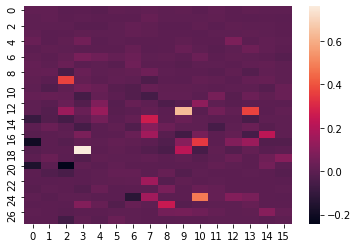

In [1613]:
head_attr = torch.einsum('lni->ln', attr['head_mask'])
_ = sns.heatmap(head_attr, cbar=True)

In [1633]:
mlp_attr.topk(5)

torch.return_types.topk(
values=tensor([0.4564, 0.3722, 0.3598, 0.3059, 0.2813]),
indices=tensor([19, 20, 17, 27, 21]))

In [1614]:
list(zip(*topk_md(head_attr, 10)))

[(18, 3, 0.7604537),
 (13, 9, 0.6324224),
 (24, 10, 0.47890106),
 (13, 13, 0.3682408),
 (9, 2, 0.36678928),
 (17, 10, 0.34165576),
 (14, 7, 0.26623338),
 (25, 8, 0.25237942),
 (16, 14, 0.22677983),
 (18, 9, 0.21567228)]

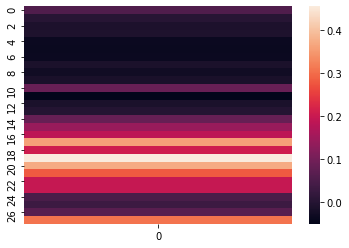

In [1624]:
mlp_attr = torch.einsum('li->l', attr['mlp_mask'])
_ = sns.heatmap(mlp_attr.unsqueeze(-1), cbar=True)

In [1634]:
list(zip(*topk_md(mlp_attr, 10)))

[(19, 0.45635837),
 (20, 0.37217423),
 (17, 0.35976774),
 (27, 0.30589604),
 (21, 0.2813289),
 (18, 0.20773941),
 (23, 0.195515),
 (22, 0.19519073),
 (16, 0.18620893),
 (15, 0.14194132)]

13 9 0.6324224


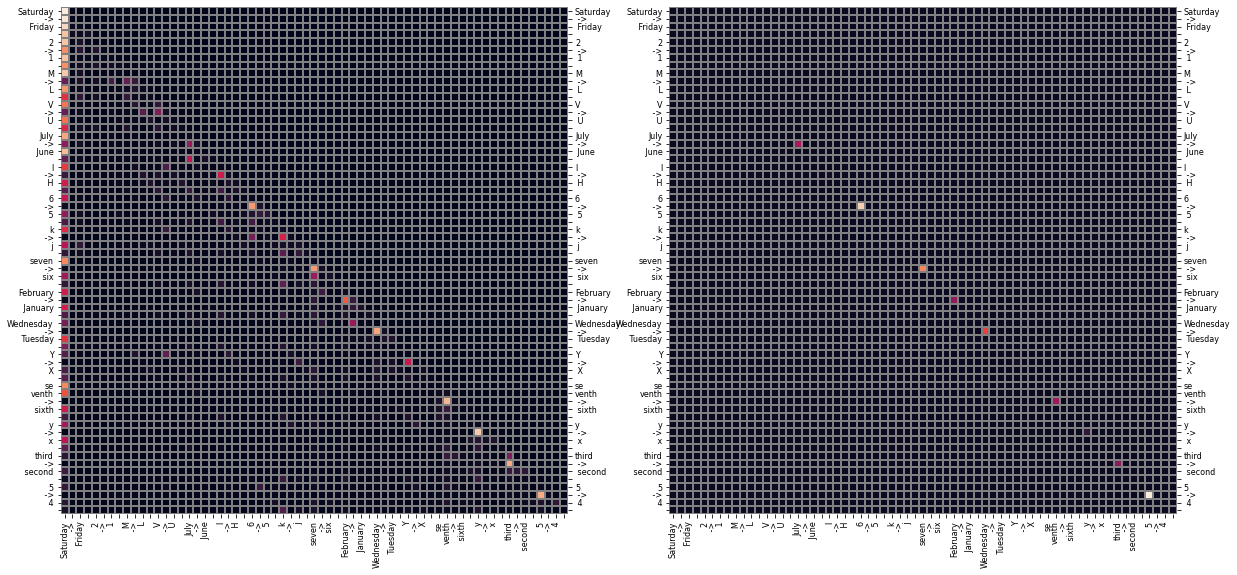

16 14 0.22677983


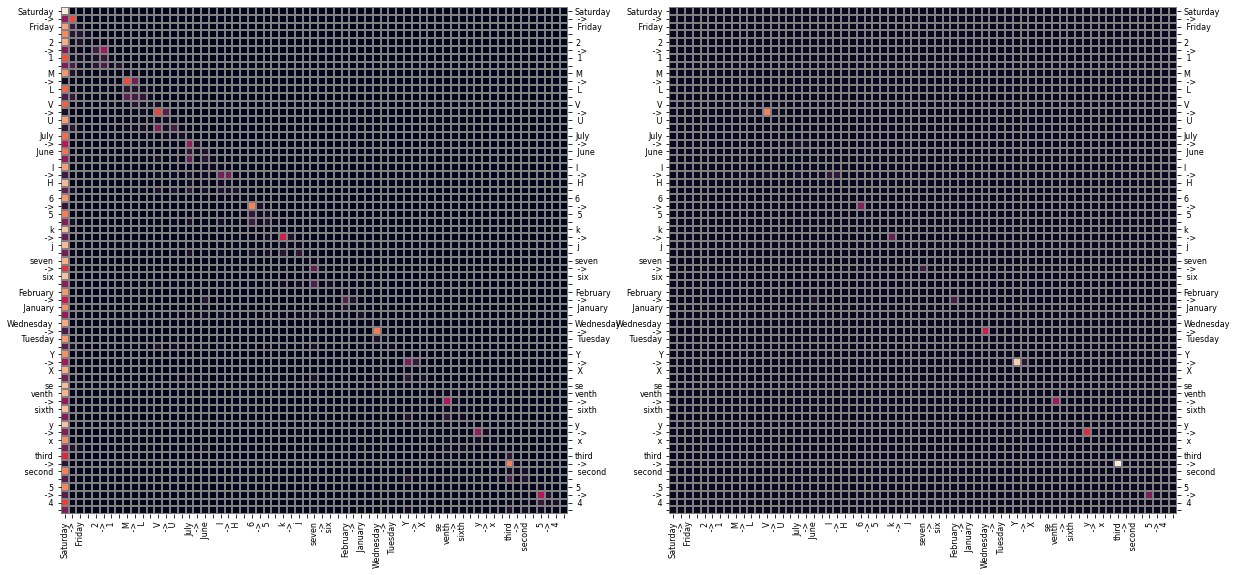

13 2 0.14248824


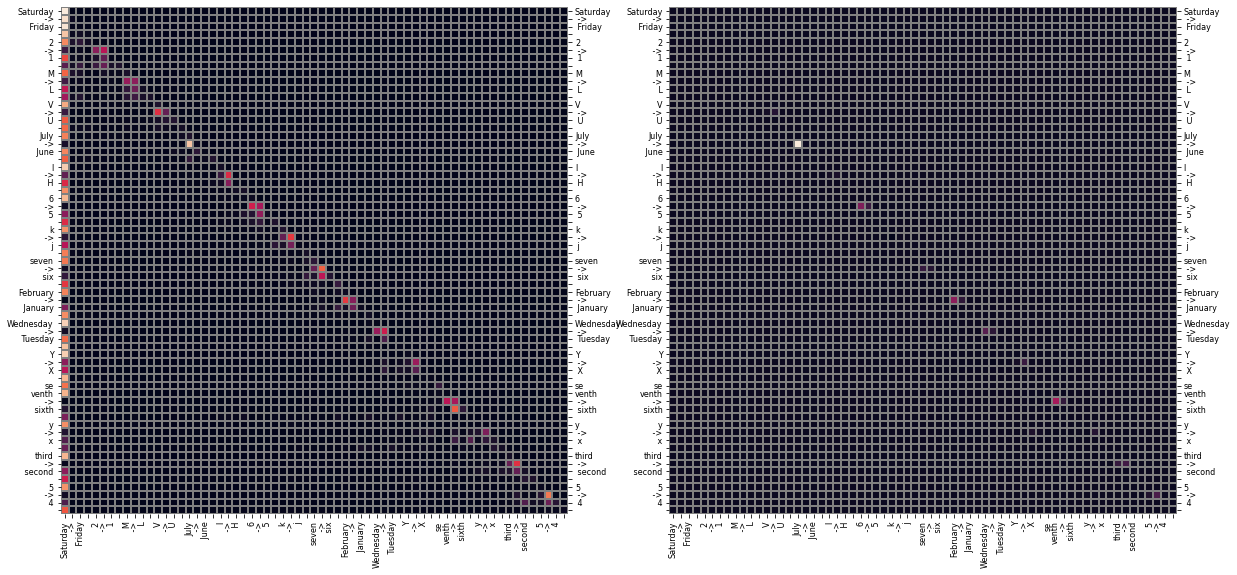

In [1623]:
# 对attn_weights归因后运行
attn_attr = attr['attn_weights']
attentions = torch.cat(o.attentions)

for l, h, v in zip(*topk_md(head_attr, 20)):
    if (l, h) not in [(13, 9), (16, 14), (13, 2)]: continue
    print(l, h, v)
    # fig, axs = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(15, 5))
    # for ax, a in zip(axs, [attentions[l, h], attn_attr[l, h], binarize(attn_attr[l, h])]):
    #     plot_attn(a, tokens, ax=ax)
    fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(20, 10))
    for ax, a in zip(axs, [attentions[l, h], attn_attr[l, h]]):#, binarize(attn_attr[l, h])]):
        plot_attn(a, tokens, ax=ax)
    plt.show()

以上用归因找到对最终预测结果起重要作用的上层heads（induction heads），  
以下用归因找到对上层induction heads的attn_weights起重要作用的下层heads（Q-compostion or K-composition with induction heads）

In [72]:
# 找第2重要的induction head（17-4）的K-composition heads
layer, head, _ = list(zip(*topk_md(head_attr, 10)))[1]
layer, head
aw_label = binarize(attn_attr[layer, head])
wq, wk = get_head_weights(layer, head)[:2]

(17, 4)

In [73]:
# 对head_output归因
query = torch.einsum('bie,de->bid', o.hidden_states[layer], wq)
head_outputs = rearrange(list(o.head_outputs), 'l 1 n i e -> 1 l n i e')[:, :layer]
key = torch.einsum('blnje,de->blnjd', head_outputs, wk)
attn_logits = torch.einsum('bid,blnjd->lnij', query, key) # b==1
# i j l n -> n_label l n -> ln
attn_head_attr = rearrange(attn_logits, 'l n i j -> i j l n')[aw_label == 1].mean(0)

In [ ]:
_ = sns.heatmap(attn_head_attr)
list(zip(*topk_md(attn_head_attr, 10)))

In [ ]:
d e q -> e
8 p v -> p
i 6 o -> 6

In [80]:
# 对attn_weights归因
# h2: a higher-layer (induction) head (layer, head)
# h1: lower-layer heads forming K-composition with h2
# i: h2 query position, j: h2 key position, k: h1 query position
head_inputs_ = rearrange(list(o.head_inputs), 'l 1 n j e -> l n j e')[:layer]
attentions_ = attentions[:layer]
if True: # faster version
    key = head_inputs_ @ wk.T  # lnje,de->lnjd
    lnkj_attn_logits = torch.einsum('bkd,lnjd->lnkj', query, key) # b==1
    lnkij_attn_logits = torch.einsum('lnij,lnkj->lnkij', attentions_, j_attn_logits)
else: # slower version, but easier to understand (similar to unseal)
    lnije = torch.einsum('lnij,lnje->lnije', attentions_[:layer], head_inputs_)
    key = lnije @ wk.T  # lnije,de->lnijd    
    lnkij_attn_logits = torch.einsum('bkd,lnijd->lnkij', query, key)  # b==1
# kij means k attends i in higher layer, i attends j in lower layer
attn_attn_attr = torch.einsum('lnkij,ki->lnij', lnkij_attn_logits, aw_label)

In [ ]:
for l, h, v in zip(*topk_md(attn_head_attr, 10)):
    print(l, h, v)
    fig, axs = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(15, 5))
    for ax, a in zip(axs, [attentions[l, h], attn_attn_attr[l, h], binarize(attn_attn_attr[l, h])]):
        plot_attn(a, tokens, ax=ax)
    plt.show()

In [473]:
all_attrs, all_yss = {}, {}

In [324]:
def qk_forward(model, outputs, layer, head, aw_label, attr_x, **mask_kwarges):
    ln = blocks[layer].ln_1
    kwargs = {x: ln(outputs.hidden_states[layer]) for x in ['hq', 'hk', 'hv']}
    kwargs[attr_x] = scaled_ln(ln, sum_forward(model, outputs, **mask_kwarges).hidden_states[0], scale=0.01) # attr_x in ['hq', 'hk']
    aw = attn_forward(blocks[layer], **kwargs)[1][:, head]
    aw_label_sum = torch.einsum('ij->', aw_label)
    # print('aw_label_sum =', aw_label_sum)
    mean_prob = torch.einsum('bij,ij->b', aw, aw_label) / aw_label_sum
    mean_logprob = torch.einsum('bij,ij->b', (aw + 1e-8).log(), aw_label) / aw_label_sum
    print('mean_prob =', mean_prob)
    print('mean_logprob =', mean_logprob)
    return mean_prob, mean_logprob

In [ ]:
# ig attribution
pred_attn = False
keys = ['aw'] #  'attn_out', 'head_out', 'attn_output', 'ffn_output'
keys2 = [] #['head_output', 'attn_output']
layer_range = (0, layer1) if pred_attn else (0, layer_out)
attrs, grads = defaultdict(list), defaultdict(list)
num_points, batch_size = 5, 5
    
for i in tqdm(range(*layer_range)):
    am = get_attn_module(blocks[i])
    scaled_emb, step, grad = {}, {}, {}
    embs = [getattr(o, keys[0])[i]]
    if len(embs) == 1 and keys[0] != 'aw': all_embs[task_name][keys[0]] = embs[0][0]
        
    for key, emb in zip(keys, embs):
        scaled_emb[key], step[key] = scaled_input(emb, num_points)
        _ = scaled_emb[key].requires_grad_(True)
        grad[key] = None
    if i == layer0: ys = []
    for j in range(0, num_points, batch_size):
        sliced_scaled_emb = [scaled_emb[key][j: j + batch_size] for key in keys]
#         for key in keys2: setattr(am if key in ['head_output'] else blocks[i], key, None)
        outputs = forward(am, keys, values=sliced_scaled_emb, exit_module=blocks[layer1+1] if pred_attn else None)
        y = globalize(outputs.attentions[layer2])[:, head2, src, tgt] if pred_attn else outputs.logits.softmax(-1)[:, src, pred_label]
#         h1 = ln1(outputs.hidden_states[12])
#         y = tgt_attn_loss(h1, _attn1, key0, residual=None, temperature=20)
        if i == layer0: ys.append(y)
#         if keys2:
#             sliced_scaled_emb2 = [getdelattr(am if key in ['head_output'] else blocks[i], key) for key in keys2]
#             sliced_scaled_emb += sliced_scaled_emb2
#             if j == num_points - batch_size: step.update({key: emb[-1:]/num_points for key, emb in zip(keys2, sliced_scaled_emb2)})
        sliced_grads = torch.autograd.grad(y.flatten().unbind(), sliced_scaled_emb)
        for gi, key in enumerate(keys + keys2):
            sliced_grad = sliced_grads[gi].sum(dim=0, keepdim=True)
            grad[key] = sliced_grad if key not in grad or grad[key] is None else grad[key] + sliced_grad
    for key in keys + keys2:
        attr = grad[key] * step[key]
        attrs[key].append(attr.data)
        grads[key].append(grad[key].data)

if len(keys) == 1:
    key = keys[0]
    all_attrs[task_name][key + str(int(pred_attn))] = torch.cat([globalize(a) for a in attrs[key]]) \
        if key == 'aw' else attrs[key][0][0]
#     for key in keys2: attrs[key] = torch.cat(attrs[key])

In [ ]:
attrs, yss = all_attrs[key], all_yss[key]

In [ ]:
dlosses = [(ys[0] - ys[-1]).item() for ys in yss]
np.array(dlosses)
_ = plt.bar(range(len(dlosses)), dlosses, 0.3)

In [248]:
# nattrs = [attr / abs(dloss) for attr, dloss in zip(attrs, dlosses)]
nattrs = [attr / attr.abs().mean() for attr in attrs]

In [251]:
mean_nattrs = torch.cat([nattr.mean(dim=-1) for nattr in nattrs])

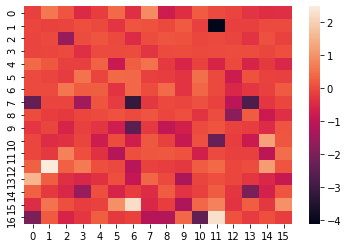

In [252]:
_ = sns.heatmap(mean_nattrs, cbar=True)

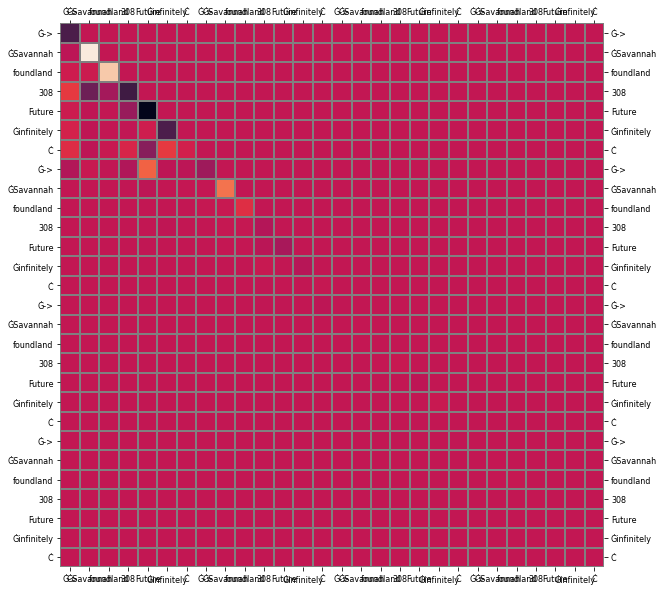

In [320]:
l, h = 6, 6
# attn = o.attentions[l][0, h]
attn = attrs[l][0, h]
plot_attn(attn, tokens)

QK circuit: $W_E^T W_Q^T W_K W_E$  
OV circuit: $W_U W_O W_V W_E$

In [230]:
def plot_eigenvalues(evs, ncols=4):
    fig, axs = plt.subplots(H // ncols, ncols, sharex=True, sharey=True, figsize=(20, 5))
    for i, (e, v) in enumerate(evs):
        e = e.detach().numpy()
        _ = axs[i // ncols][i % ncols].plot(e[:,0], e[:,1], '.')

In [281]:
WQK, WOV = [], []
for l in tqdm(range(L)):
    WQK.append([combine_weights(get_head_weights(l, h), qk=True) for h in range(H)])
    WOV.append([combine_weights(get_head_weights(l, h), qk=False) for h in range(H)])

100%|██████████| 24/24 [00:05<00:00,  4.48it/s]


In [284]:
WQK = [[combine_weights(get_head_weights(l, h), qk=True) for h in range(H)] for l in tqdm(range(L))]
WOV = [[combine_weights(get_head_weights(l, h), qk=False) for h in range(H)] for l in tqdm(range(L))]

100%|██████████| 24/24 [00:01<00:00, 20.26it/s]


In [333]:
# rwqk2, rwov1 = torch.rand(hidden_size, hidden_size) * 10, torch.rand(hidden_size, hidden_size) * 100

# rwq, rwk = torch.rand(hidden_size // H, hidden_size)*10, torch.rand(hidden_size // H, hidden_size)
# rwo, rwv = torch.rand(hidden_size, hidden_size // H), torch.rand(hidden_size // H, hidden_size)*100
# rwqk2, rwov1 = rwq.t().mm(rwk), rwo.mm(rwv)

# rwqk2.mm(rwov1).norm() / (rwqk2.norm() * rwov1.norm())

K-composition: $\text{Id} \otimes A^{h_{-1}} \otimes (W_E^T W_{QK}^h W_{OV}^{h_{-1}} W_E)$, measured by Frobenius norm ratio: $||W_{QK}^{h_2}W_{OV}^{h_1}||_F \mathbin{/} (||W_{QK}^{h_2}||_F ||W_{OV}^{h_1}||_F)$

In [345]:
dl = 3
kcomp3 = np.array([[[(WQK[l][h2].mm(WOV[l-dl][h1]).norm() / (WQK[l][h2].norm() * WOV[l-dl][h1].norm())).item() 
          for h1 in range(H)] for h2 in range(H)] for l in tqdm(range(dl, L))])

100%|██████████| 21/21 [01:23<00:00,  3.96s/it]


In [386]:
def scatter_plot(a): a = a.detach().numpy(); plt.plot(a[:,0], a[:,1], '.')

In [74]:
chains = [
    [(4, 14), (3, 3)],  # 0.24024388
    [(5, 4), (2, 2)],  # 0.21996385
    [(5, 4), (3, 7)],  # 0.31488344
    [(6, 6), (3, 3)],  # 0.27304175
    [(6, 6), (5, 3)],  # 0.12567882
]

In [314]:
(l2, h2), (l1, h1) = chains[4]

In [433]:
e = WQK[l2][h2].mm(WOV[l1][h1]).eig()[0]

In [435]:
e[:10] = 0

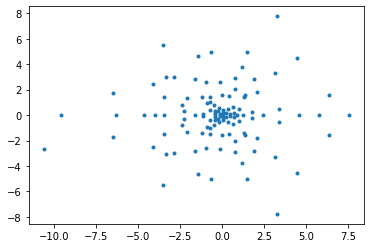

In [436]:
scatter_plot(e)

In [437]:
e = WOV[l2][h2].eig()[0]

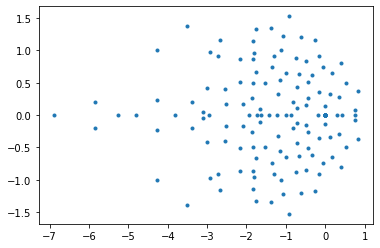

In [438]:
scatter_plot(e)

In [356]:
a = kcomp3[2]; ind = np.unravel_index(a.argmax(), a.shape); ind, a[ind]

((4, 2), 0.21996384859085083)

<AxesSubplot:>

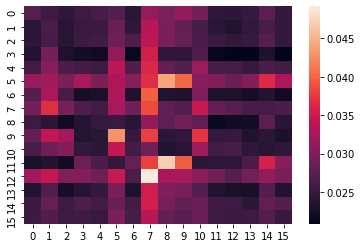

In [319]:
kcomp = np.array(kcomp)
sns.heatmap(kcomp, cbar=True)

In [364]:
wov_evs = [torch.eig(combine_weights(get_head_weights(3, h), qk=False, with_embedding=True, BA=True)) for h in tqdm(range(H))]

100%|██████████| 16/16 [00:02<00:00,  7.17it/s]


  0%|          | 0/16 [3:32:06<?, ?it/s]


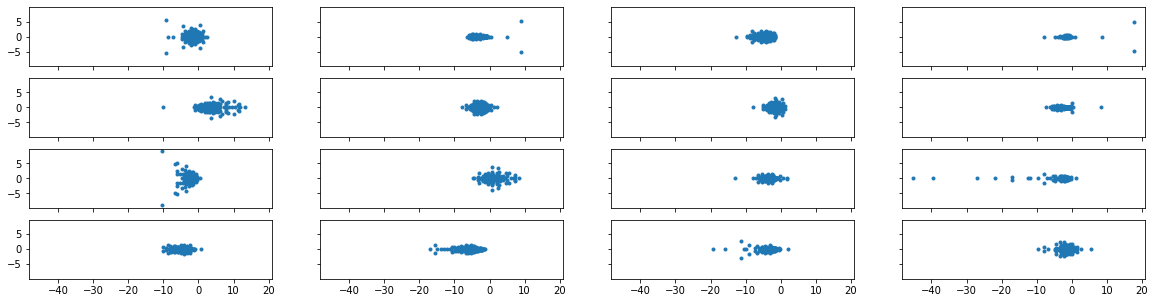

In [363]:
plot_eigenvalues(wov_evs)

In [138]:
w_eu = w_e.matmul(w_u)

In [522]:
def mlp(layer): return lambda x: blocks[layer].mlp(blocks[layer].ln_2(x))
def mlp0(layer): return lambda x: blocks[layer].mlp(x)

In [186]:
def attn(layer): return lambda x: blocks[layer].attn(blocks[layer].ln_1(x))

In [537]:
w_e2 = w_e * 50
w_eu2 = (w_e2 + mlp0(L-1)(w_e2)).matmul(w_u)

In [ ]:
# grad attribution
pred_attn = False
keys = ['aw'] #  'attn_out', 'head_out', 'attn_output', 'ffn_output'
keys2 = [] #['head_output', 'attn_output']
layer_range = (0, layer1) if pred_attn else (0, layer_out)
attrs, grads = defaultdict(list), defaultdict(list)
num_points, batch_size = 5, 5
    
for i in tqdm(range(*layer_range)):
    am = get_attn_module(blocks[i])
    scaled_emb, step, grad = {}, {}, {}
    embs = [getattr(o, keys[0])[i]]
    if len(embs) == 1 and keys[0] != 'aw': all_embs[task_name][keys[0]] = embs[0][0]
        
    for key, emb in zip(keys, embs):
        scaled_emb[key], step[key] = scaled_input(emb, num_points)
        _ = scaled_emb[key].requires_grad_(True)
        grad[key] = None
    if i == layer0: ys = []
    for j in range(0, num_points, batch_size):
        sliced_scaled_emb = [scaled_emb[key][j: j + batch_size] for key in keys]
#         for key in keys2: setattr(am if key in ['head_output'] else blocks[i], key, None)
        outputs = forward(am, keys, values=sliced_scaled_emb, exit_module=blocks[layer1+1] if pred_attn else None)
        y = globalize(outputs.attentions[layer2])[:, head2, src, tgt] if pred_attn else outputs.logits.softmax(-1)[:, src, pred_label]
#         h1 = ln1(outputs.hidden_states[12])
#         y = tgt_attn_loss(h1, _attn1, key0, residual=None, temperature=20)
        if i == layer0: ys.append(y);
#         if keys2:
#             sliced_scaled_emb2 = [getdelattr(am if key in ['head_output'] else blocks[i], key) for key in keys2]
#             sliced_scaled_emb += sliced_scaled_emb2
#             if j == num_points - batch_size: step.update({key: emb[-1:]/num_points for key, emb in zip(keys2, sliced_scaled_emb2)})
        sliced_grads = torch.autograd.grad(y.flatten().unbind(), sliced_scaled_emb)
        for gi, key in enumerate(keys + keys2):
            sliced_grad = sliced_grads[gi].sum(dim=0, keepdim=True)
            grad[key] = sliced_grad if key not in grad or grad[key] is None else grad[key] + sliced_grad
    for key in keys + keys2:
        attr = grad[key] * step[key]
        attrs[key].append(attr.data)
        grads[key].append(grad[key].data)

if len(keys) == 1:
    key = keys[0]
    all_attrs[task_name][key + str(int(pred_attn))] = torch.cat([globalize(a) for a in attrs[key]]) \
        if key == 'aw' else attrs[key][0][0]
#     for key in keys2: attrs[key] = torch.cat(attrs[key])

In [ ]:
plot_attn(globalize(attentions[8])[0, 2], figsize=(20, 20))

In [5395]:
for i, token in enumerate(tokens):
    if token in ['Ċ', '^']: print()
    else: print('%2d %s' %(i, token), end='  ')
tgt_positions


 1 E   2 N   3 K   4 R   5 ->   6 N  
 8 A   9 T  10 D  11 7  12 ->  13 T  
15 Q  16 A  17 P  18 K  19 ->  20 A  
22 A  23 N  24 L  25 5  26 ->  27 N  
29 V  30 1  31 P  32 B  33 ->  34 1  
36 G  37 V  38 7  39 4  40 ->  41 V  
43 R  44 Y  45 J  46 P  47 ->  48 Y  
50 A  51 C  52 S  53 Y  54 ->  55 C  


tensor([ 2,  9, 16, 23, 30, 37, 44, 51])

In [5409]:
a = all_attrs[task_name]['aw' + str(int(pred_attn))]
a = a / a.view(a.size(0), -1).norm(dim=1)[:, None, None, None] #.view(a.size(0), 1, 1, 1)
if not pred_attn:
    src_indices, tgt_indices = [src], [tgt]
    _a = a[:, :, src_indices, tgt_indices]
    values, indices = _a.view(_a.size(0), H, -1).topk(1, dim=-1)
    show_top_heads(values, indices, src_indices=src_indices, tgt_indices=tgt_indices)
    print()
# src_indices = numpy(ans_positions[:])
# src_indices = numpy(tgt_positions + 1)
# tgt_indices = tgt_positions
_a = a[:, :, src_indices, :]
values, indices = _a.view(_a.size(0), H, -1).topk(nrows // 2, dim=-1)
show_top_heads(values, indices, src_indices=src_indices)#, tgt_indices=tgt_indices)

16-15	0.918 [(51, 0.918, 66.8)]	0.13030353 *0.66812056 0.011132528 0.0006797812 
14-0	0.783 [(51, 0.783, 66.5)]	0.14255618 *0.6645065 0.019694159 0.0019851688 
17-13	0.705 [(51, 0.705, 49.8)]	0.18755053 *0.49829417 0.078217894 0.10344336 
13-2	0.505 [(51, 0.505, 44.5)]	0.43078056 *0.44530356 0.017190581 0.001503151 
17-17	0.213 [(51, 0.213, 40.9)]	0.16368316 *0.4086181 0.24944614 0.11208218 
14-13	0.192 [(51, 0.192, 32.8)]	0.20337617 *0.32792574 0.07777147 0.073093265 
15-8	0.159 [(51, 0.159, 22.5)]	0.15539594 *0.22527154 0.26876858 0.27620015 
14-16	0.101 [(51, 0.101, 26.3)]	0.11579089 *0.2628595 0.104256935 0.014017421 
15-16	0.099 [(51, 0.099, 13.2)]	0.13631786 *0.1315605 0.098822616 0.30740336 
13-12	0.095 [(51, 0.095, 13.1)]	0.44031265 *0.13147357 0.035518978 0.05850061 
13-3	0.078 [(51, 0.078, 34.5)]	0.46285912 *0.34470326 0.08684665 0.0354087 
7-2	0.062 [(51, 0.062, 27.9)]	0.105706446 *0.2786354 0.16776893 0.2326701 
17-1	0.047 [(51, 0.047, 46.0)]	0.38024765 *0.45963302 0.023335

In [5408]:
def show_top_heads(values, indices, src_indices=None, tgt_indices=None, topk=15):
    val, ind = values.sum(dim=-1).view(-1).topk(topk)
    val, ind = numpy(val), unravel_index(ind, values.size()[:-1])
    for (l, h), v in zip(ind, val):
        _l = l + layer_range[0]
        if _l <= 3: continue
        top_links = list(zip(unravel_index(indices[l, h], (seq_len, seq_len)), numpy(values[l, h], decimals=3)))
        if src_indices is not None: top_links = [([src_indices[_s], _t], _v) for [_s, _t], _v in top_links]
        if tgt_indices is not None: top_links = [([_s, tgt_indices[_t]], _v) for [_s, _t], _v in top_links]
        top_links = [([_s, _t], _v, numpy(globalize(attentions[_l]) * 100, decimals=1)[0, h, _s, _t]) for [_s, _t], _v in top_links]
        _top_links = [([_s, _t], _v, _a) if len(src_indices) > 1 else (_t, _v, _a) for [_s, _t], _v, _a in top_links]
        print('%d-%d\t%.3f' % (_l, h, v), _top_links, end='\t') 
        if len(top_links) == 1:
            probs = numpy(globalize(attentions[_l])[0, h, src])
            for i in cand_range:
                if i == tgt: print('*', end='')
                print(probs[i], end=' ')
        print()

tensor([0.6156])


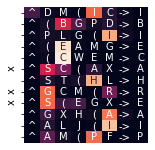

In [5057]:
a = globalize(attentions[layer2])[:, head2]
# a = a.softmax(-1)
a = torch.cat([a[:, i - 1: i, i - ncols - 2: i + 1] for i in ans_positions], dim=1)
# a = a.softmax(-1)
loss = a.view(a.size(0), -1)[:, tgt_positions[1:]].mean(dim=1)
print(loss)
plot_tgt_attn(a[0])

In [3455]:
wvos = [torch.matmul(*get_head_weights(l, h)[2:]) for l, h in [(11, 8), (12, 18)]]
wqk = torch.matmul(*get_head_weights(13, 2)[:2])
ww = wvos[0].matmul(wvos[1]).matmul(wqk)

In [3735]:
ww.norm(dim=0).topk(40).indices

tensor([2484,   88,  578, 1781,  586,  408, 2054,  304,  824, 1675, 1772,  501,
        2456, 1019,  936, 2463, 2368,  340, 2418,  101, 1734,  687, 2159, 1060,
          20, 1838,  224, 1669, 1187,  870, 1585,  232,  281, 1474, 1729,  328,
        1860, 1174,  816, 1524])

In [3741]:
show_topk(*aw.view(-1).topk(20, largest=False), indices_fn=indices_fn)

{(578, 586): -0.0016085216,
 (578, 88): -0.0011706072,
 (936, 1782): -0.0011014504,
 (578, 501): -0.0009034774,
 (578, 114): -0.00086396607,
 (578, 1761): -0.00080681103,
 (578, 1067): -0.0007989705,
 (936, 814): -0.00079893926,
 (936, 405): -0.00076955673,
 (936, 336): -0.0007586547,
 (578, 2149): -0.00074234203,
 (578, 1666): -0.0007264766,
 (578, 408): -0.00071433355,
 (578, 1019): -0.00066249806,
 (936, 946): -0.00065255526,
 (2484, 1675): -0.00064498984,
 (578, 1675): -0.0006330121,
 (578, 1651): -0.00062471436,
 (936, 1445): -0.00062095723,
 (578, 289): -0.0006184878}

In [4065]:
wvos2 = [torch.matmul(*get_head_weights(l, h)[2:]) for l, h in [(9, 9), (10, 1), (12, 18)]]
ww2 = reduce(torch.matmul, wvos2 + [wqk])

In [5015]:
attn_output1, out = None, None
out_proj_w = self1.out_proj.weight.view(hidden_size, H, -1).permute(1, 2, 0).unsqueeze(0)
head_mask = torch.zeros(H, seq_len, seq_len)
head_mask[[18,]] = 1
# head_mask[:] = 1
attn1 = attentions[layer1]
_attn1, __attn1 = torch.zeros_like(attn1), torch.zeros_like(attn1)
for i in range(0, nrows):
    _attn1[:, :, arrow_positions[i], ans_positions[i]] = 1
    __attn1[:, :, arrow_positions[i], ans_positions[:i]] = 1 / i if i > 0 else 0
    
def ffn(layer, x): return blocks[layer].mlp(blocks[layer].ln_2(x))

def tgt_attn_loss(h1, attn1, key0, residual=None, attn_output_w=1, apply_softmax=True, temperature=10, 
                  positions=tgt_positions, plot=False, ax=None):
    def get_attn(attn_output):
        out = (residual if residual is not None else 0) + attn_output * attn_output_w
        if residual is not None: out = out + ffn(layer1, out)
        if residual is not None: out = ln2(out)
        query = out.matmul(wq2.t()).unsqueeze(2) # (bsz, nrows, d_head) -> (bsz, nrows, 1, d_head), ln2 is omissible
        key = key0.matmul(wk2.t()).view(bsz, nrows, ncols + 3, hidden_size // H)
        a = (query * key).sum(-1) # (bsz, nrows, ncols + 3)
        a[:, :, [-1]] = -1e9
        if apply_softmax: a = (a / temperature).softmax(-1)
        return a

    self1.w = attn1 * head_mask; attn_output1 = self1(h1)[0] - self1.out_proj.bias
    a = get_attn(attn_output1[:, arrow_positions])
    loss = a.view(a.size(0), -1)[:, positions]
    if plot:
#         a = a - a.min(dim=2, keepdim=True).values
        plot_tgt_attn(a[0], ax=ax)#; print(loss)
    return loss.mean()

residual = None or hidden_states[layer1][:, arrow_positions]

[0.7721180319786072, 0.9933991432189941, 0.9961371421813965]

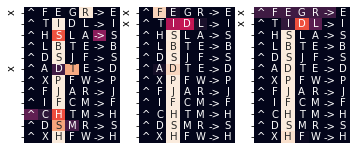

In [5052]:
def get_ln(layer): return blocks[layer].ln_1
# 10-ffn, 9-11 for find special, 9-11 for AbCD->B/b, 9-11 for ABCD->C
# 10-19+ffn+8!, 9-11 for after bracket 5-5/7, 9-11, 10-1+13+ffn+8+19 for in brackets
mask = torch.zeros(H, seq_len, 1); mask[11] = 1#; mask[:] = 0 # 11-8, 10-1, 9-11,   9-11/6?->8-17 for 2nd
# for i in range(0, nrows): mask[1, ans_positions[i], tgt_positions[i]+1] = 1
layer0 = 9
self0, ln0 = get_attn_module(blocks[layer0]), blocks[layer0].ln_1

h0 = hidden_states[9]*0 + head_outputs[8][:, [17]].sum(1)*1
self0.w = attentions[layer0] * mask; attn_output0 = self0((h0), attention_masks[layer0])[0] - self0.out_proj.bias
# h1 = hidden_states[9]*0 + head_outputs[11][:, [8]].sum(1)*1 #+ ffn_outputs[10]#+ head_outputs[11][:, [8,]].sum(1)*1
# h1 = ln1(h1)
h1 = attn_output0
key0 = get_ln(10)(hidden_states[10])#; key0.reqires_grad = True; key0.retain_grad()
fig, axes = plt.subplots(1, 3, sharey=False, figsize=(2.5 * (ncols + 3) / 9 * 3, 5 * nrows / 24))
# loss = tgt_attn_loss(h1, __attn1, key0, residual=None, plot=True, apply_softmax=True, temperature=1, ax=axes[0]); loss
# print('after', key0[:, :, 0])
[tgt_attn_loss(h1, attn, key0, residual=None,plot=True,temperature=1, positions=tgt_positions[(i>0)*2:],ax=ax).item() 
    for i, (attn, ax) in enumerate(zip([_attn1, attn1, __attn1], axes))]
# if losses[0] > 0.8 and losses[-1] > 0.8: print(layer, head, losses)

In [5075]:
def get_weight_norm(w):
    return w.abs().mean().item()

In [5083]:
wvo1 = get_combined_w(9, 11) * get_combined_w(12, 18)
for layer in [8, ]:
    for head in range(H):
        wvo = get_combined_w(layer, head)
        print('%d-%d %.4f %.4f' % (layer, head, get_weight_norm(wvo.matmul(wvo1)) / get_weight_norm(wvo), get_weight_norm(wvo.matmul(wvo1))))

8-0 0.0865 0.0030
8-1 0.0865 0.0016
8-2 0.0866 0.0026
8-3 0.0870 0.0027
8-4 0.0867 0.0019
8-5 0.0873 0.0022
8-6 0.0874 0.0027
8-7 0.0867 0.0023
8-8 0.0867 0.0021
8-9 0.0879 0.0026
8-10 0.0874 0.0023
8-11 0.0866 0.0024
8-12 0.0870 0.0024
8-13 0.0868 0.0023
8-14 0.0866 0.0017
8-15 0.0870 0.0023
8-16 0.0874 0.0029
8-17 0.0865 0.0014
8-18 0.0876 0.0025
8-19 0.0866 0.0024


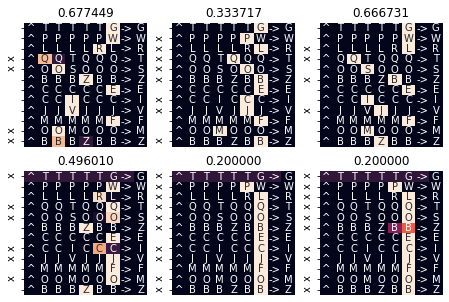

In [4950]:
front_chains = [
    [[(11, 8), create_mask(ans_positions, tgt_positions)]],
    [[(9, 9), create_mask(tgt_positions + 1, tgt_positions)], [(10, 1), create_mask(ans_positions, tgt_positions + 1)]],
]
rear_chains = [
    [[(12, 18), create_mask(arrow_positions, ans_positions)], [(13, 2), None]],
    [[(12, 18), create_mask(arrow_positions, ans_positions, accum=True)], [(13, 2), None]],
]

sum_a = {i: 0 for i in range(len(rear_chains))}
fig, axes = plt.subplots(2, 3, sharey=False, figsize=(2.5 * (ncols + 3) / 9 * 3, 5 * nrows / 24 * 2))
for j, front_chain in enumerate(front_chains):
    l0 = front_chain[0][0][0]
    h = h0 = get_ln(l0)(hidden_states[l0])
    for (layer, head), mask in front_chain:
#         attn = globalize(attentions[layer])[:, head] #if layer in [9] else mask
        attn = mask
        wvo = get_combined_w(layer, head)
        h = attn.matmul(h.matmul(wvo))
    for i, rear_chain in enumerate(rear_chains):
        (layer, head), mask = rear_chain[0]
        attn = mask
        wvo = get_combined_w(layer, head)
        q = attn.matmul(h.matmul(wvo))
        wqk = get_combined_w(*rear_chain[-1][0], qk=True)
        q = q.matmul(wqk)[:, arrow_positions].unsqueeze(2)
        k = h0.view(h0.size(0), nrows, ncols + 3, hidden_size)
        a = q.matmul(k.transpose(-1, -2)).squeeze(2) / 1
        a[:, :, [-1]] = -1e9
        sum_a[i] = sum_a[i] + a
        a = a.softmax(-1)
        loss = a.view(a.size(0), -1)[:, tgt_positions[i*2:]].mean()#; print('%.3f' % loss.item(), end=' ')
        plot_tgt_attn(a[0], ax=axes[i, j], title='%f' % loss.item())

for i in range(len(rear_chains)):
    a = sum_a[i]
    a = a.softmax(-1)
    loss = a.view(a.size(0), -1)[:, tgt_positions[i*2:]].mean()#; print('%.3f' % loss.item(), end=' ')
    plot_tgt_attn(a[0], ax=axes[i, 2], title='%f' % loss.item())

In [4602]:
_sattn, __sattn = torch.zeros(1, seq_len, seq_len), torch.zeros(1, seq_len, seq_len)
for i in range(0, nrows):
    _sattn[:, arrow_positions[i], tgt_positions[i]] = 1
    __sattn[:, arrow_positions[i], tgt_positions[:i]] = 1 / i if i > 0 else 0

0.157 0.497 0.250 
0.100 0.809 0.264 


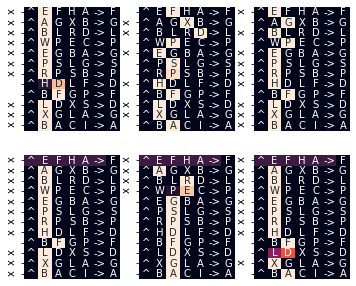

In [4605]:
ww0 = torch.eye(hidden_size)
# layer = 9; ln = blocks[layer].ln_1
# h0 = key0 = ln(hidden_states[layer])
fig, axes = plt.subplots(2, 3, sharey=False, figsize=(2.5 * (ncols + 3) / 9 * 3, 5 * nrows / 24 * 2))
for i, attn in enumerate([_sattn, __sattn]):
    sum_a = 0
    for j, (w, layer) in enumerate([(ww, 11), (ww2, 9)]):
        ln = blocks[layer].ln_1
        h0 = key0 = ln(hidden_states[layer])
        query = attn.matmul(h0)[:, arrow_positions].matmul(w).unsqueeze(2)
        key = key0.view(key0.size(0), nrows, ncols + 3, hidden_size)
        a = (query * key).sum(-1) / 1
        a[:, :, [-1]] = -1e9
        sum_a = sum_a + a
        a = a.softmax(-1)
        loss = a.view(a.size(0), -1)[:, tgt_positions[i*2:]].mean(); print('%.3f' % loss.item(), end=' ')
        plot_tgt_attn(a[0], ax=axes[i, j])
    a = sum_a.softmax(-1)
    loss = a.view(a.size(0), -1)[:, tgt_positions[i*2:]].mean(); print('%.3f' % loss.item(), end=' ')
    plot_tgt_attn(a[0], ax=axes[i, 2])
    print()

In [3719]:
aw = ww * ww.grad

In [3721]:
aw.norm(dim=0).topk(10)

torch.return_types.topk(
values=tensor([0.0037, 0.0029, 0.0027, 0.0025, 0.0023, 0.0023, 0.0018, 0.0016, 0.0016,
        0.0016], grad_fn=<TopkBackward>),
indices=tensor([  88,  586, 2484,  408, 1782,  578, 1781, 1019,  405, 1761]))

In [4962]:
head_outputs[9][0, :, ans_positions].norm(dim=-1).mean(-1).topk(10)

torch.return_types.topk(
values=tensor([12.2424, 11.6219, 11.3335, 10.7489,  9.3170,  9.2139,  8.5213,  7.5385,
         6.7957,  6.3538]),
indices=tensor([ 9, 19, 11,  7, 14,  6,  4, 10,  0,  8]))

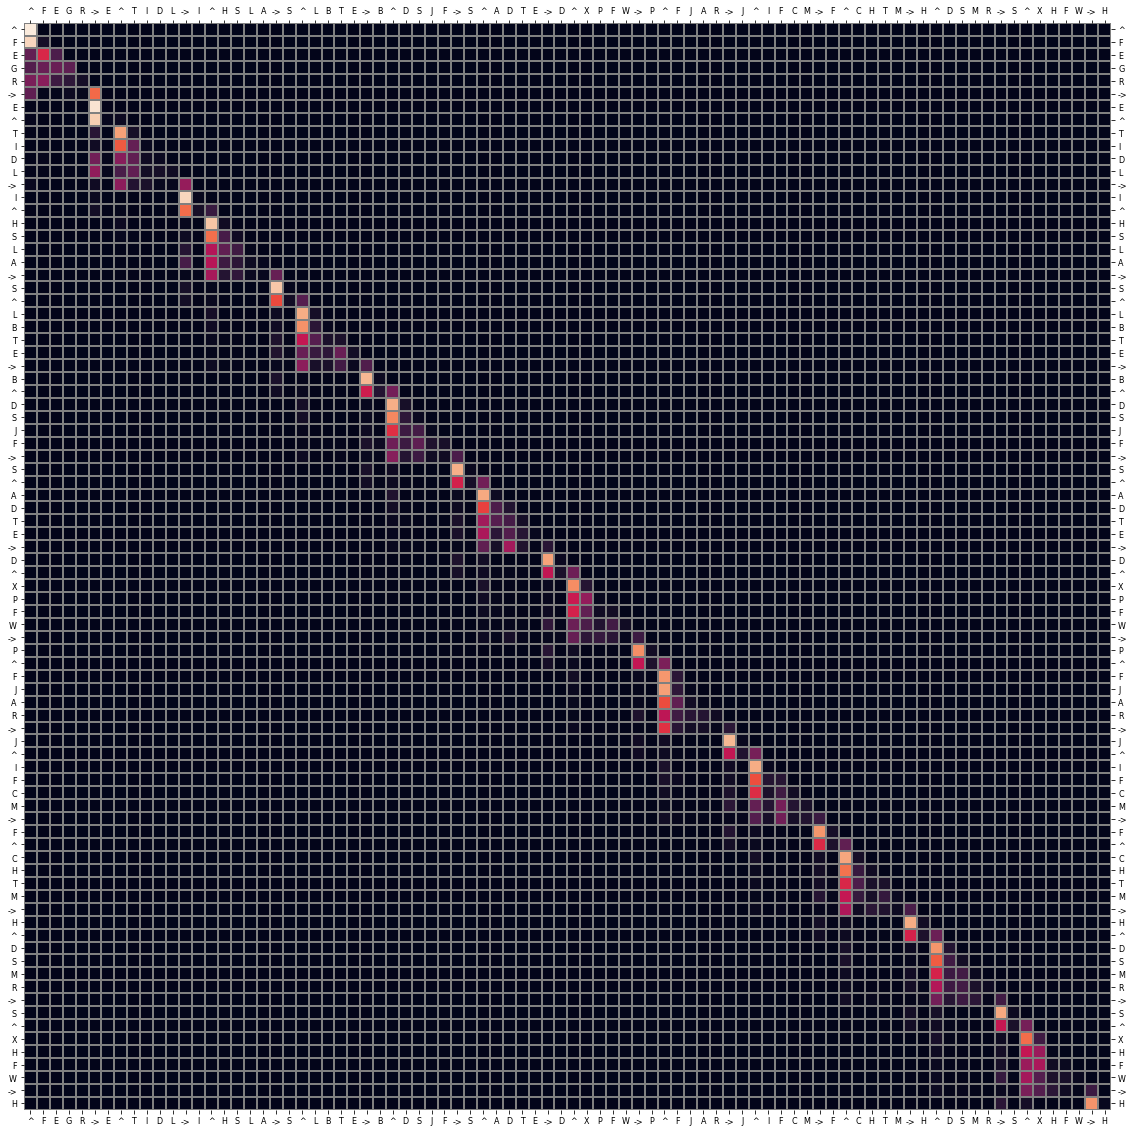

In [5037]:
plot_attn(globalize(attentions[9])[0, 6], figsize=(20, 20))

In [3360]:
a0 = head_outputs[9][0, 11, ans_positions]
a1 = head_outputs[11][0, 8, ans_positions]

In [3362]:
a0 = attrs['head_output'][9, 11, ans_positions]
a1 = attrs['head_output'][11, 8, ans_positions]

In [3363]:
cos = nn.CosineSimilarity(dim=1)
cos(a0, a1)

tensor([0.0226, 0.1145, 0.0712, 0.1595, 0.0533, 0.0150, 0.1125, 0.1410, 0.0172,
        0.0142, 0.0040, 0.0719])

In [3336]:
attr = attrs['attn_output'].sum(-1)
attr = attr / attr.view(attr.size(0), -1).norm(dim=1)[:, None]

<AxesSubplot:>

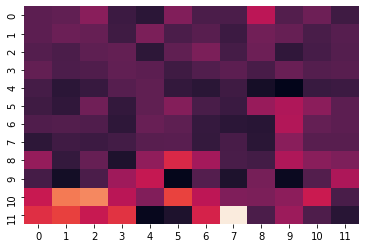

In [3337]:
sns.heatmap(numpy(attr[:, ans_positions]), cbar=False)

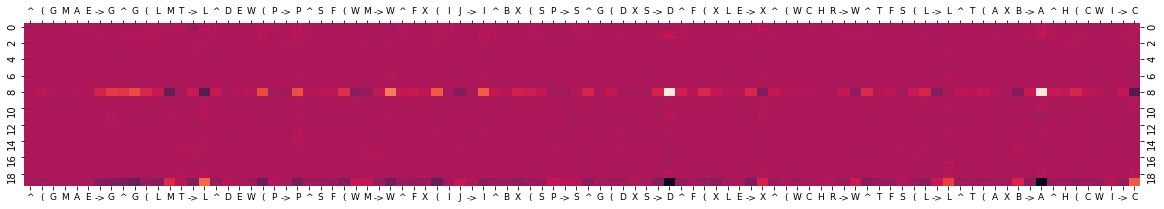

In [3887]:
_ = plt.figure(figsize=(20, 3))
ax = sns.heatmap(numpy(attrs['head_output'].sum(-1)[10]), cbar=False, xticklabels=tokens)
_ = ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=9, rotation=0)
ax.tick_params(top=True, right=True, labeltop=True, labelright=True)

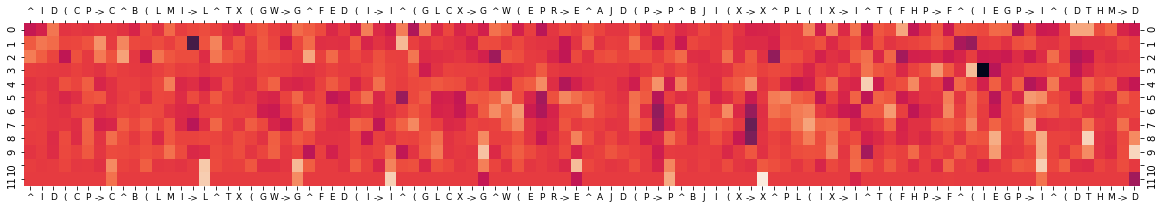

In [3303]:
_ = plt.figure(figsize=(20, 3))
ax = sns.heatmap(numpy(attr), cbar=False, xticklabels=tokens)
_ = ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=9, rotation=0)
ax.tick_params(top=True, right=True, labeltop=True, labelright=True)

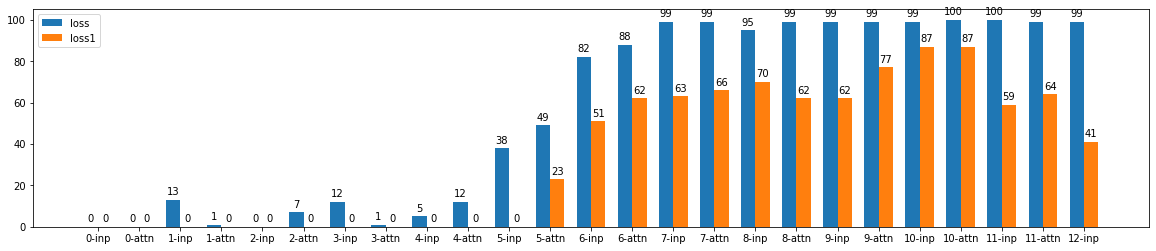

In [616]:
ffn_w = 0
results = []
for i in range(0, layer1 + 1):
    h1 = hidden_states[i] - hidden_states[0]*1
    residual = None #or hidden_states[layer1][:, arrow_positions]
    losses = [tgt_attn_loss(h1, attn, residual=residual, ffn_w=ffn_w) for attn in [_attn1, attn1]]
    results.append(('%d-inp' % i, losses[0], losses[1]))
    if i < layer1:
        losses = [tgt_attn_loss(h1 + attn_outputs[i], attn, residual=residual, ffn_w=ffn_w) 
                  for attn in [_attn1, attn1]]
        results.append(('%d-attn' % i, losses[0], losses[1]))
plot_tgt_attn_losses(*zip(*results))

10 tensor(0.2207, grad_fn=<MeanBackward0>)


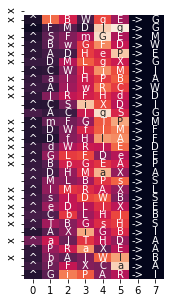

In [2149]:
a = []
tgt_h = hidden_states[layer0][0, tgt_positions]
h0 = hidden_states[layer0].view(nrows, ncols + 3, hidden_size)
for i in range(nrows):
    q = tgt_h[0:i].mean(dim=0)
    q = ln2(q).matmul(wq2.t())
    k = ln2(h0[i]).matmul(wq2.t())
#     attn1 = globalize(attentions[layer1]) * head_mask
#     attn_output1 = torch.matmul(attn1, _head_output1).sum(1)
#     q = ln2(attn_output1[:, arrow_positions[i]]).matmul(wq2.t())
#     q = ln2(_attn_output1[:, ans_positions][:, i:i+1].mean(1)).matmul(wq2.t())
#     k = key[i]
    a.append((q * k).sum(-1).unsqueeze(0))  # == torch.matmul(q, k.t())

a = torch.cat(a)
a[:, -2:] = -1000000
a = a.softmax(-1)
plot_tgt_attn(a)

In [3153]:
layer1, head1 = 12, 18
layer0, head0 = 11, 8
layer2, head2 = 13, 2  #17-4 for A[B]C->B,A*BC->B, 13-5 for reverse set diff
self0, self1, self2 = get_attn_module(blocks[layer0]), get_attn_module(blocks[layer1]), get_attn_module(blocks[layer2])

h_mask = torch.ones(hidden_size)
h_mask[top_i[0]] = 0

ln0, ln1, ln2 = blocks[layer0].ln_1, blocks[layer1].ln_1, blocks[layer2].ln_1
# mean, var = forward(blocks[layer2], 'ln1_mean_var')

wq0, wk0, wv0, wo0 = get_head_weights(layer0, head0)
wq1, wk1, wv1, wo1 = get_head_weights(layer1, head1)
wq2, wk2, wv2, wo2 = get_head_weights(layer2, head2)

In [3396]:
attn_output0, ffn_output0 = forward(blocks[layer0], ['attn_output', 'ffn_output'], exit_module=blocks[layer0],
                                    extra_tuples=[(get_attn_module(blocks[layer0]), 'hidden_states_mask', h_mask)])
head_output0 = forward(get_attn_module(blocks[layer0]), 'head_output', exit_module=blocks[layer0],
                        extra_tuples=[(get_attn_module(blocks[layer0]), 'hidden_states_mask', h_mask)])

10


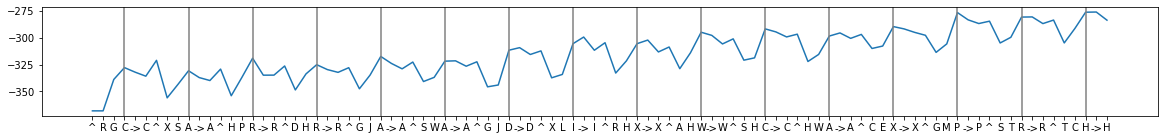

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 
 tensor(1.0000, grad_fn=<MeanBackward0>)


In [1202]:
## h1 = ln1(hidden_states[10]*0 + attn_output0 * 1 + ffn_output0 * 1)
h1 = ln1(hidden_states[layer0]*1 + attn_outputs[10]*1 + ffn_outputs[10] * 1 + attn_outputs[11] * 1 + ffn_outputs[11] * 1)

self1.head_output, self1.attn_output = None, None
self1.w = attentions[layer1]
try: _ = self1(h1, attention_mask=attention_masks[layer1])
finally:
    head_output1, attn_output1 = getdelattr(self1, 'head_output'), getdelattr(self1, 'attn_output')
    try_delattr(self1, 'w')

query = get_query(self2, ln2(hidden_states[layer1]*0 + attn_output1*1 + attn_outputs[13]*0))
# query = get_query(self2, ln2(head_output1[:, [16, 18]].sum(1)))
# query = get_query((self2, head_outputs[layer1][:, head1]))
# query = get_query(self2, attn_hidden_states[layer2])
for layer in [layer0]:#range(layer2 + 1):
    key2 = get_key(self2, ln2(hidden_states[layer]))
#     key2 = get_key(self2, ln2(attn_outputs[9]))
    logits = (query * key2).sum(dim=-1)
    print(layer)
    _ = test(None, None, logits=logits, always_show=True)

In [73]:
emb = all_embs[task_name][key]
emb_attr = all_attrs[task_name][key + str(int(pred_attn))]

In [2881]:
layer0 = 10
# layer, head = 10, 8  # ABC->B, ABC->A(pred_attn<12-18), ABC->C(only pred_attn), find lowercase, set diff2(only pred_attn)
layer, head = 12, 18 # 12-16, 12-18, 12-1 ABC->A, ABC,AXC->X, set diff2, set diff
layer2, head2 = 13, 2  # ABC->B, ABC->A, ABC->C, ABC,AXC->X, set diff, set diff2(<13-12), find lowercase(<15-8)
# layer2, head2 = 15, 8  # 15-8, find lowercase
# layer2, head2 = 13, 12  # set diff2, ABC,AXC->X(<13-2)

In [483]:
positions = tgt_positions[1:]
offsets = [torch.zeros_like(positions) - 1, torch.zeros_like(positions), torch.zeros_like(positions) + 1]
labels = numpy(torch.cat(offsets))
for layer in range(layer2):
    for head in range(H):
        emb = numpy(torch.cat([attn_outs[layer][0, head, positions + offset] for offset in offsets]))
#         emb = numpy(torch.cat([head_outputs[layer][0, head, positions + offset] for offset in offsets]))
        head_output = head_outputs[layer][:, head]
        if cluster(emb, labels)[0]:# and test(head_output, always_show=False) is not None:
#         if test(head_output, always_show=False) is not None:
            visualize_by_pca(emb, labels)
#             attn = globalize(attentions[layer])[0, head]
#             plot_attn(attn)
            print(layer, head)

(tensor([0.0174, 0.0392, 0.0546, 0.0641, 0.0408, 0.2807, 0.1289, 0.1209, 0.0977],
        grad_fn=<IndexBackward>),
 tensor(0.8444, grad_fn=<SumBackward0>))

(tensor([0.6571, 0.1062, 0.3671, 0.5548, 0.2617, 0.7426, 0.6988, 0.5396, 0.8236,
         0.6873], grad_fn=<SelectBackward>),
 tensor(0.5439, grad_fn=<MeanBackward0>))

(tensor([1.1355e-16, 3.7752e-13, 7.8185e-12, 6.1335e-10, 5.1372e-08, 3.3332e-06,
         3.1391e-04, 5.4327e-03, 1.5451e-01, 5.4892e-01],
        grad_fn=<IndexBackward>),
 tensor(0.0709, grad_fn=<MeanBackward0>))

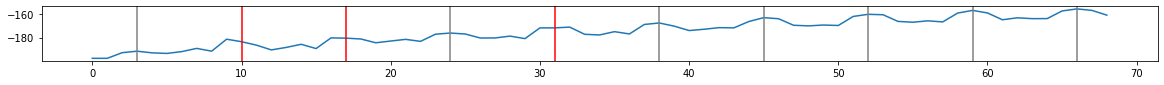

True

In [2023]:
layer0, head0 = 10, 1 #11-14  10-1
h_mask2 = torch.ones(hidden_size)
h_mask2[top_i[:]] = 0

attn_mask = torch.ones(H, seq_len, hidden_size // H)
# attn_mask[:, :] = 0
# attn_mask[8, :] = .1
m = get_attn_module(blocks[layer2])
outputs = forward(get_attn_module(blocks[layer0]), 'attn_mask', attn_mask, exit_module=blocks[layer2],
                 extra_tuples=[(m, 'return_attn_logits', True), #(m, 'hidden_states_mask', h_mask2),
#                                (get_attn_module(blocks[10]), 'hidden_states_mask', h_mask2),
                               (get_attn_module(blocks[layer1]), 'w', attentions[layer1])
                              ])

probs0 = outputs.attentions[layer1][0, head1, src, ans_positions[:-1]]
probs0, probs0.sum()
logits = globalize(outputs.attentions[layer2])[0, head2, src, : src + 1]
probs = logits[cand_positions].view(-1, n_candidates).softmax(-1)[:, task_name2idx[task_name]]
probs, probs.mean()
probs = logits.softmax(-1)[tgt_positions]
probs, probs.mean()
test(None, None, logits=logits)

tensor([[0.0066, 0.0076, 0.1356, 0.0835, 0.2636, 0.0631, 0.2177]],
       device='cuda:2')
tensor([0.0143, 0.0143, 0.0143, 0.0143, 0.0143, 0.0143, 0.0143],
       device='cuda:2')
{'44 a': 0.3398, '42 ^': 0.2043, '43 Y': 0.1879, '38 I': 0.0659, '41 v': 0.0539}


{'Ġa': 0.3382, 'Ġv': 0.2697, 'ĠY': 0.0545, 'Ġu': 0.042, 'Ġy': 0.0365}

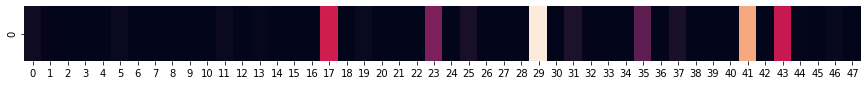

In [261]:
m = blocks[layer].attn.attention
mask = torch.ones(H, seq_len, seq_len)
# mask[:, src] = 0
mask[:] = 0
mask[head, src] = 0.1
_ = mask.requires_grad_(True)
# m.attn_mask = mask

# scaled_attn = attentions[layer] * mask.to(model.device)
# _ = scaled_attn.requires_grad_(True)
# m.w = scaled_attn
try:
    with torch.no_grad(): outputs = model(**inputs, output_attentions=True)
    attn = outputs.attentions[layer]
    _ = plt.figure(figsize=(15, 1))
    _ = sns.heatmap(numpy(attn[:, head, src, :]), cbar=False)
    print(attn[:, head, src, ans_positions[:-1]])
    
    attn[:] = 0
#     attn[0, head, src] = 0
    attn[0, head, src, ans_positions[:-1]] = 0.1 / len(ans_positions[:-1])
#     i = random.randint(0, attn.size(3) - 1); i
#     attn[0, head, src] = 0.1 / attn.size(3)
    print(attn[0, head, src, ans_positions[:-1]])
    m.w = attn
    with torch.no_grad(): outputs = model(**inputs, output_attentions=True)
#     outputs = model(**inputs, output_attentions=True)
finally:
#     m.attn_mask = None
    m.w = None
# y = outputs.logits.softmax(-1)[:, src, pred_label]
# mask_grad = torch.autograd.grad(torch.unbind(y), mask)[0]
# attn_grad = torch.autograd.grad(torch.unbind(y), scaled_attn)[0]
    
attn = globalize(outputs.attentions[layer2])[0, head2, src]
print(show_topk(*attn.topk(5), indices_fn=append_tokens_to_positions))
probs = outputs.logits[0, src].softmax(-1)
show_topk(*probs.topk(5), indices_fn=tokenizer.convert_ids_to_tokens)

In [209]:
attn_grad[0, head - 2].mean()

tensor(0.0001, device='cuda:2')

In [169]:
attn_grad.size()
attn_grad2.size()
(attn_grad2[4:5] - attn_grad).abs().max()
attn_grad[0, head, src, ki]
attn_grad2[4, head, src, ki]

torch.Size([1, 20, 72, 72])

torch.Size([10, 20, 72, 72])

tensor(6.2585e-05, device='cuda:2')

tensor([-0.2539, -0.2229, -0.2132, -0.1997, -0.1915, -0.1745, -0.1862],
       device='cuda:2')

tensor([-0.2539, -0.2229, -0.2132, -0.1997, -0.1915, -0.1745, -0.1862],
       device='cuda:2')

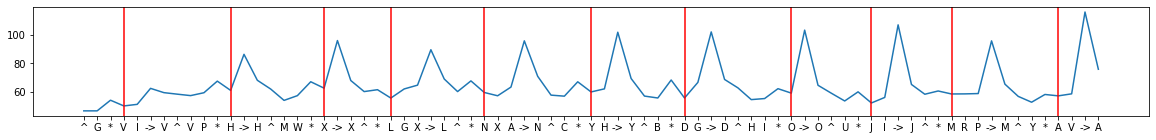

[0.017 0.002 0.011 0.    0.    0.001 0.    0.044 0.    0.088 0.13 ] 
 tensor(0.0266, grad_fn=<MeanBackward0>)


In [3504]:
qh = ln2(hidden_states[layer1]*0 + attn_output1*1 + attn_outputs[13]*1)[:, src:src+1]
kh = attn_hidden_states[layer2]
# kh = ln2(attn_outputs[9])
logits = (qh * kh).sum(dim=-1).squeeze(0)
_ = test(None, None, logits=logits, always_show=True)

In [11]:
texts = {
    'find lowercase': '''
X C e -> e
S f Z -> f
K y N -> y
q M N -> q
u S N -> u
S v Y -> v
v I J -> v
Y a N -> a''',
    'AbC->B': '''
X C e -> E
S f Z -> F
K y N -> Y
q M N -> Q
u S N -> U
S v Y -> V
g I J -> G
Y a N -> A
L n J -> N
d H I -> D
Z r C -> R
U S t -> T
K r A -> R
I G m -> M
t O X -> T''',  # failed, but GPT-3 can with low prob
    'set diff': '''
G L C, G L -> C
Y P J, Y P -> J
E S A, S A -> E
U P W, U P -> W
W Z A, W A -> Z
Z Q J, Z J -> Q
C Y L, Y L -> C
C K Z, C Z -> K
K O Q, O Q -> K
K O N, K N -> O
R U P, R P -> U
X C J, X C -> J
B G V, G V -> B
H V L, H V -> L
J K M, J M -> K
N W K, W K -> N
F B D, F B -> D''',
    'find majority': '''
n d d -> d
f f d -> f
e b e -> e
s q s -> s
d d o -> d
c e e -> e
g t g -> g
i i w -> i''', # basically failed
    'find special': '''
n d d -> n
f f d -> d
e b e -> b
s q s -> q
d d o -> o
c e e -> c
g g t -> t
w i i -> w''',  # failed, GPT-3 failed, too
    'find special2': '''
n d d d -> n
f f f d -> d
e b e e -> b
s s q s -> q
d d d o -> o
e c e e -> c
g g g t -> t
w i i i -> w''',  # failed, but GPT-3 can
    'ABC,AXC->X': '''
D O Q, K O Q -> K
K H N, K O N -> O
R X P, R U P -> U
X C G, X C J -> J
Z G V, B G V -> B
H V T, H V L -> L
J E M, J K M -> K
A W K, U W K -> U
F B Y, F B D -> D''',
    'reverse set diff': '''
O Q, K O Q -> K
K N, K O N -> O
R P, R U P -> U
X C, X C J -> J
G V, B G V -> B
H V, H V L -> L
J M, J K M -> K
W K, N W K -> N
F B, F B D -> D''',
    'set diff2': '''
Z Y, y -> z
K B, b -> k
N E, e -> n
J S, j -> s
O W, o -> w
F R, f -> r
J S, s -> j
N O, o -> n
P R, p -> r''',
    'find next': '''
W S D L, S -> D
F M W Q, F -> M
T W A V, A -> V
U V N M, N -> M
S D N O, S -> D
A S B T, S -> B
H W L Z, H -> W
C L J O, J -> O
T B A E, B -> A
L G C K, L -> G
G B S O, G -> B
K Y F O, F -> O
V Q U S, V -> Q
S E Y P, Y -> P
X D A U, A -> U
T L M N, L -> M
U O Y I, O -> Y''',  # failed, GPT-3 failed too
    'antonym': '''
big -> small
low -> high
fast -> slow
dark -> light
long -> short''',
}

In [ ]:
try:
#     with torch.no_grad(): outputs = model(**inputs, output_attentions=True)
#     attn = outputs.attentions[layer]
#     print(attn[0, head, src, ans_positions[:-1]])
#     attn[0, head, src] = 0
#     attn[0, head, src, ans_positions[-8]] = 1
#     print(attn[0, head, src, ans_positions[:-1]])
#     m.w = attn
    with torch.no_grad(): outputs = model(**inputs, output_attentions=True)
finally:
    m.attn_mask = None
#     m.w = None

In [258]:
def norm(tensor): return round(tensor.abs().mean().item(), 4)
hidden_states.mean(), hidden_states.std()
for l in range(layer, layer2):
    print(norm(hidden_states), end=' ')
    hidden_states = hidden_states + h[l].attn_output
    print(norm(h[l].attn_output), norm(hidden_states), hidden_states.mean(), hidden_states.std())
    print(norm(hidden_states), end=' ')
    hidden_states = hidden_states + h[l].ffn_output
    print(norm(h[l].ffn_output), norm(hidden_states), hidden_states.mean(), hidden_states.std())

(tensor(-0.7157, device='cuda:2'), tensor(17.1320, device='cuda:2'))

2.3035 0.7521 2.545 tensor(-0.7262, device='cuda:2') tensor(17.2453, device='cuda:2')
2.545 0.7547 2.7227 tensor(-0.7361, device='cuda:2') tensor(17.7049, device='cuda:2')
2.7227 0.7046 2.9372 tensor(-0.7366, device='cuda:2') tensor(17.8712, device='cuda:2')
2.9372 0.8032 3.1048 tensor(-0.7600, device='cuda:2') tensor(18.7369, device='cuda:2')
3.1048 0.8814 3.2894 tensor(-0.7694, device='cuda:2') tensor(18.9570, device='cuda:2')
3.2894 0.8759 3.2595 tensor(-0.7893, device='cuda:2') tensor(19.1697, device='cuda:2')


In [257]:
_hidden_states = h[layer2].ln_1(hidden_states)
try:
    with torch.no_grad(): _, attn = am2(am2_hidden_states, am2_attention_mask, output_attentions=True, q_hidden_states=_hidden_states)
finally: am2.q_hidden_states = None
attn = globalize(attn)
attn[0, head2, -1].topk(5)

torch.return_types.topk(
values=tensor([0.4904, 0.3162, 0.0501, 0.0432, 0.0416], device='cuda:2'),
indices=tensor([42, 43, 36, 44, 46], device='cuda:2'))

In [326]:
with torch.no_grad(): outputs = model(**inputs, output_attentions=True)
attn = globalize(outputs.attentions[layer2])[0, head2, -1]
show_topk(*attn.topk(5), indices_fn=append_tokens_to_positions)
probs = outputs.logits[0, -1].softmax(-1)
show_topk(*probs.topk(5), indices_fn=tokenizer.convert_ids_to_tokens)

for l in range(layer, layer + 1):
    mask_tgt_indices = [41, 35, 29, 23, 17, 11, 5]
    excluded_src_indices = [seq_len - 1] #if l == layer else []
    attn = outputs.attentions[l]
    if attn.dim() == 5:
        attn = attn[:, 0, :, :, -seq_len:] # (bsz, num_blokcs, H, seq_len, window_size + seq_len) -> (bsz, H, seq_len, seq_len)
#     for hd in range(H):
#         for src_idx in range(seq_len):
#             if hd != head and src_idx in excluded_src_indices:
#                 attn[:, hd, src_idx] = 0
    for hd in range(H):
        for src_idx in range(seq_len):
            for tgt_idx in range(seq_len):
                if hd == head and src_idx not in excluded_src_indices and tgt_idx in mask_tgt_indices:
                    attn[:, hd, src_idx, tgt_idx] = 0
    h[l].attn.attention.w = outputs.attentions[l]
try:
    with torch.no_grad(): outputs = model(**inputs, output_attentions=True)
finally:
    for l in range(layer, layer2):
        h[l].attn.attention.w = None
attn = globalize(outputs.attentions[layer2])[0, head2, -1]
show_topk(*attn.topk(5), indices_fn=append_tokens_to_positions)
probs = outputs.logits[0, -1].softmax(-1)
show_topk(*probs.topk(5), indices_fn=tokenizer.convert_ids_to_tokens)

{'44 E': 0.7865, '43 V': 0.1431, '38 K': 0.0355, '45 H': 0.0323, '37 A': 0.001}

{'ĠE': 0.8562, 'ĠH': 0.1216, 'ĠV': 0.0133, 'ĠD': 0.0009, 'ĠI': 0.0007}

{'28 ->': 0.6616,
 '40 ->': 0.3003,
 '22 ->': 0.0244,
 '34 ->': 0.013,
 '16 ->': 0.0003}

{'ĠT': 0.2914, 'ĠC': 0.1015, 'ĠL': 0.0839, 'ĠY': 0.0793, 'ĠE': 0.0643}

In [70]:
head_attrs = all_attrs['A B C D -> a'].sum(dim=(2, 3))
# head_attrs = attrs.sum(dim=(2, 3))

values, indices = head_attrs[:, :].view(-1).topk(10)
indices = unravel_index(indices, head_attrs.size())
top_heads = [(l, h, round(v, 8)) for l, h, v in zip(
    indices[0].tolist(), indices[1].tolist(), values.tolist())]
top_heads

[(17, 1, 1.08707237),
 (19, 21, 1.00648546),
 (21, 13, 0.78149551),
 (17, 10, 0.68284625),
 (17, 15, 0.63359404),
 (18, 18, 0.62241864),
 (22, 15, 0.52263898),
 (20, 5, 0.45230082),
 (19, 17, 0.36873266),
 (21, 4, 0.33636701)]

In [26]:
inputs = tokenizer.encode_plus(_text, return_tensors='pt')
outputs = model(**inputs, output_attentions=True)

logits = outputs.logits if hasattr(outputs, 'logits') else outputs[0]
y = logits[0, -1].max()
attentions = outputs.attentions if hasattr(outputs, 'attentions') else outputs[-1]
for a in attentions: a.retain_grad()
model.zero_grad()
y.backward()

# attns = torch.cat(attentions)
grads = torch.cat([a.grad for a in attentions])
attrs2 = attns * grads

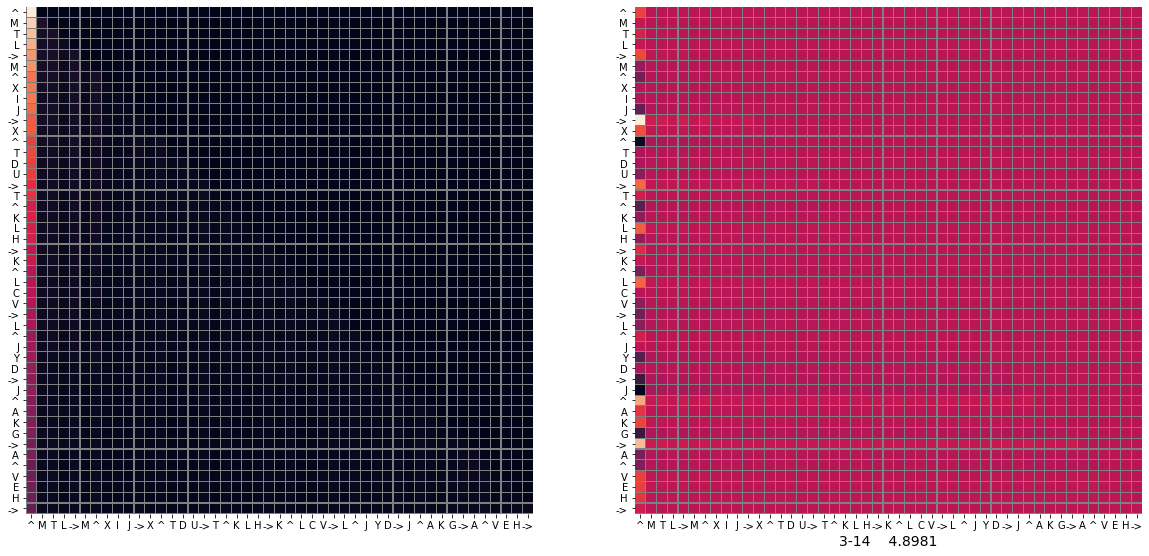

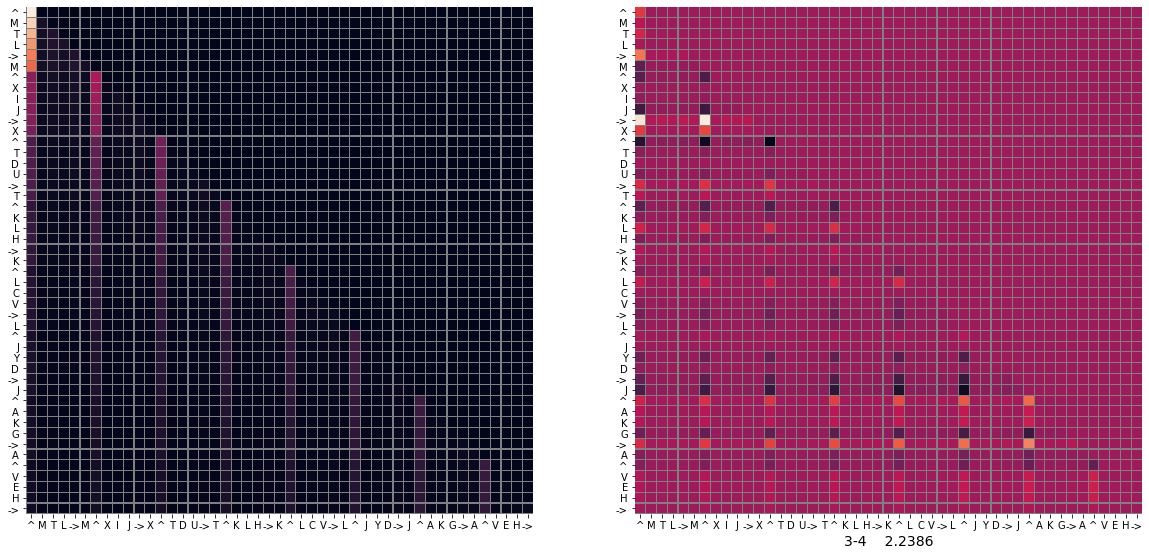

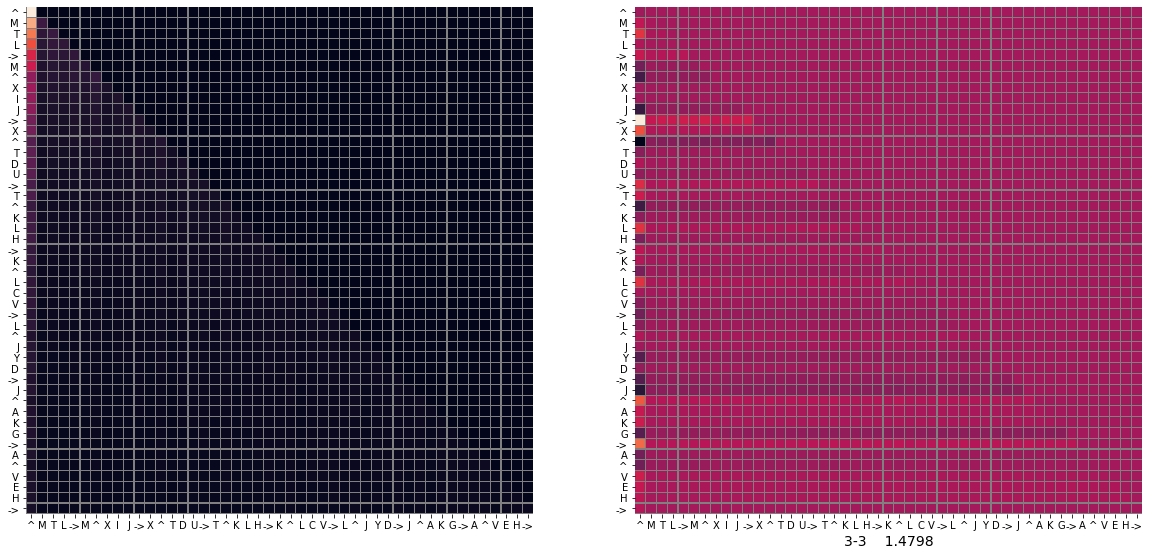

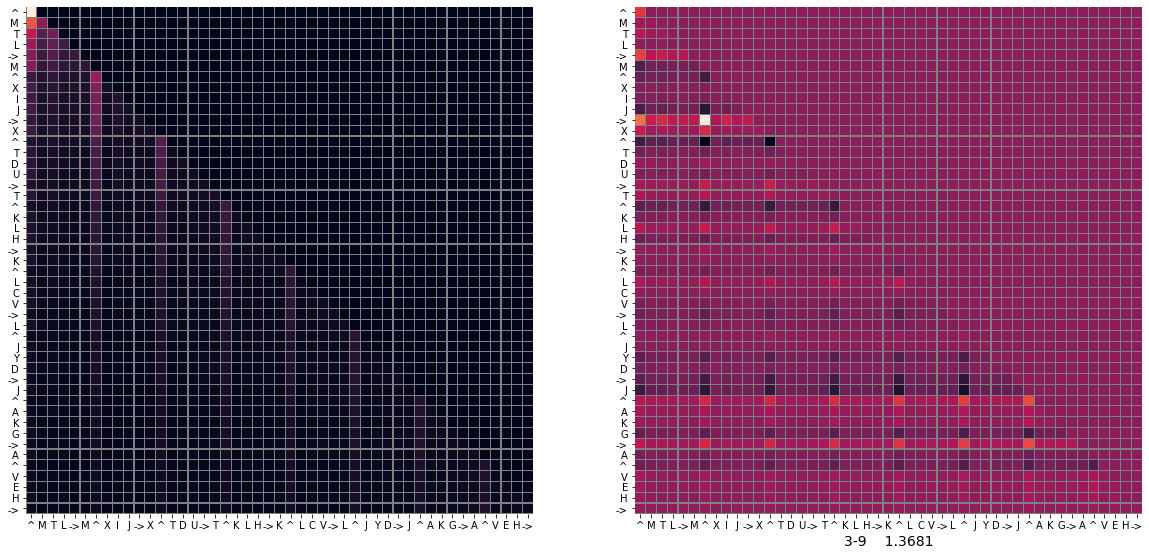

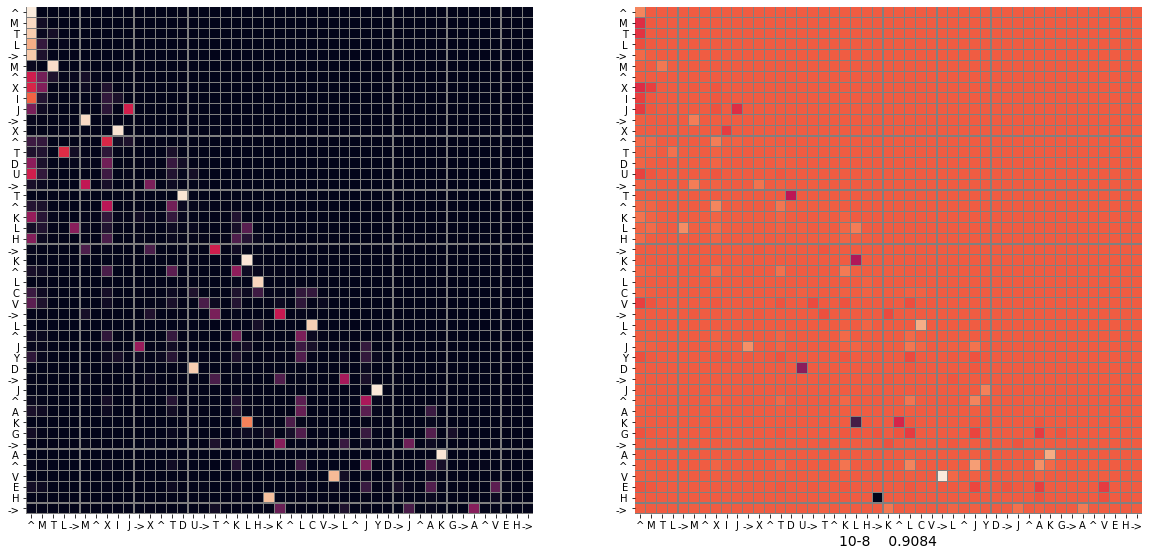

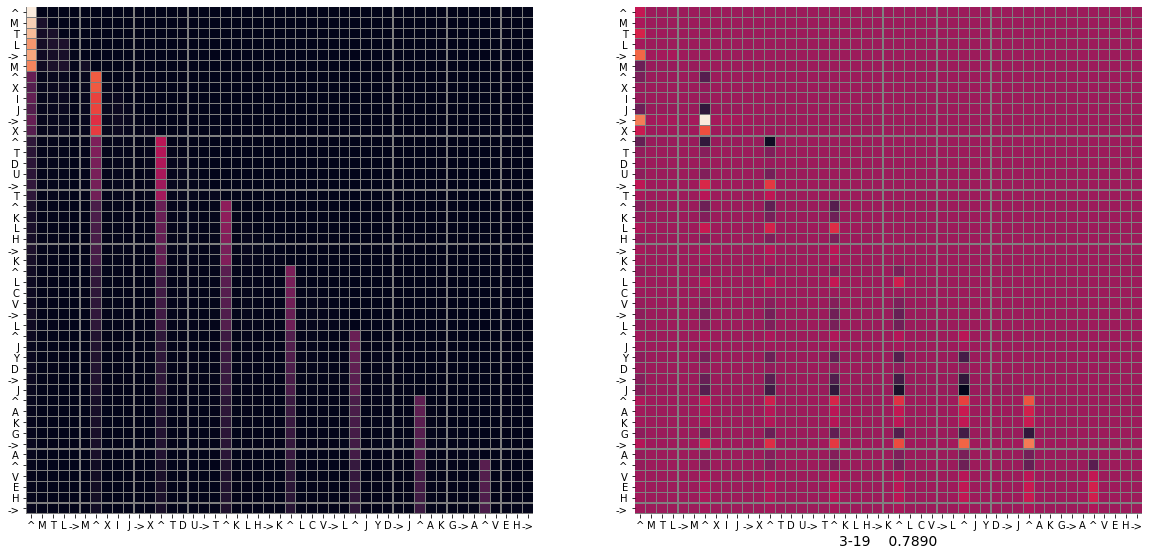

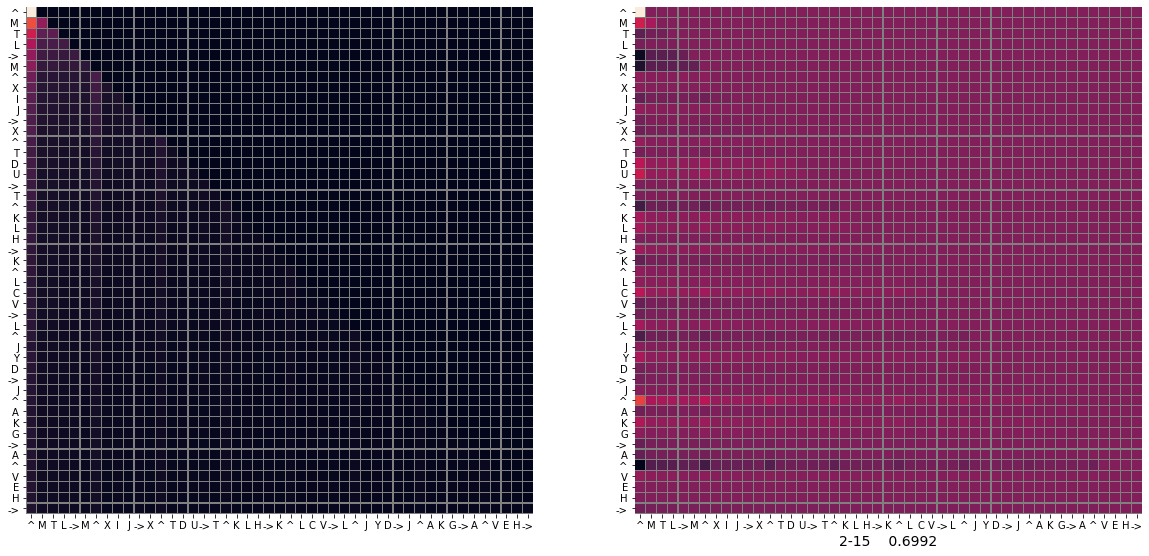

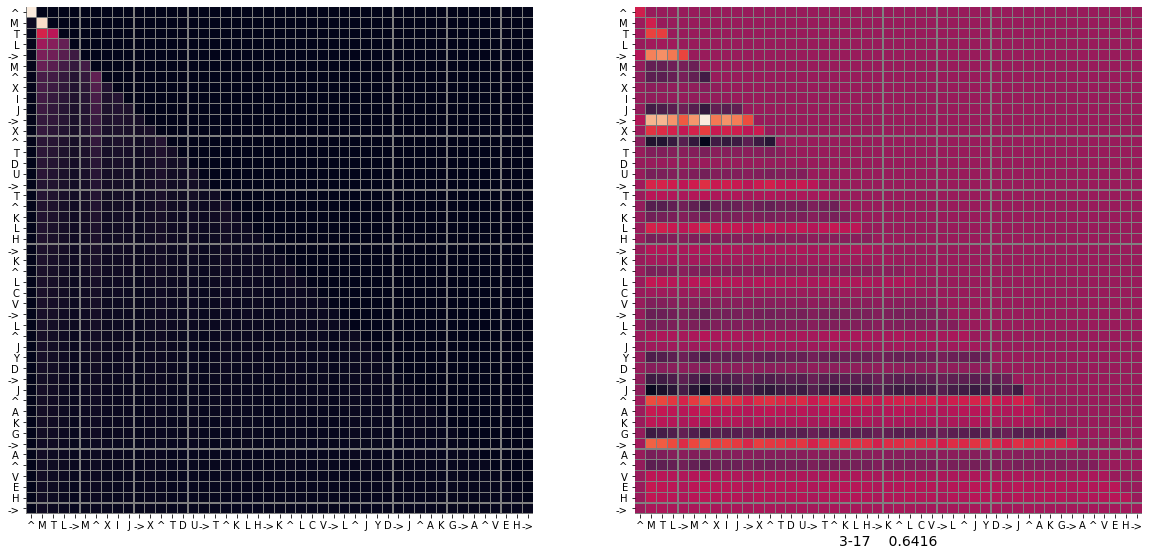

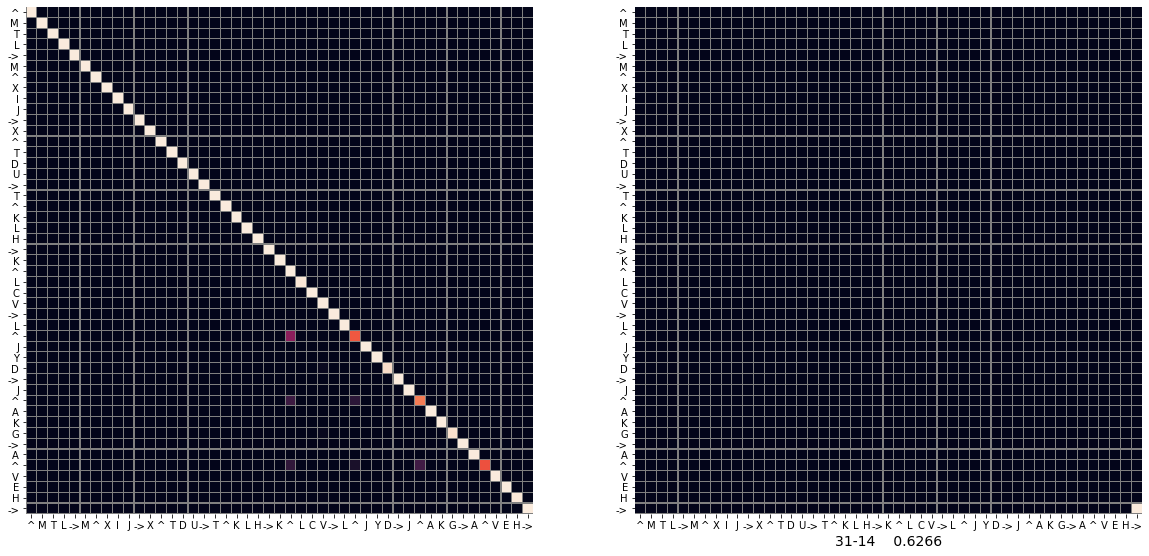

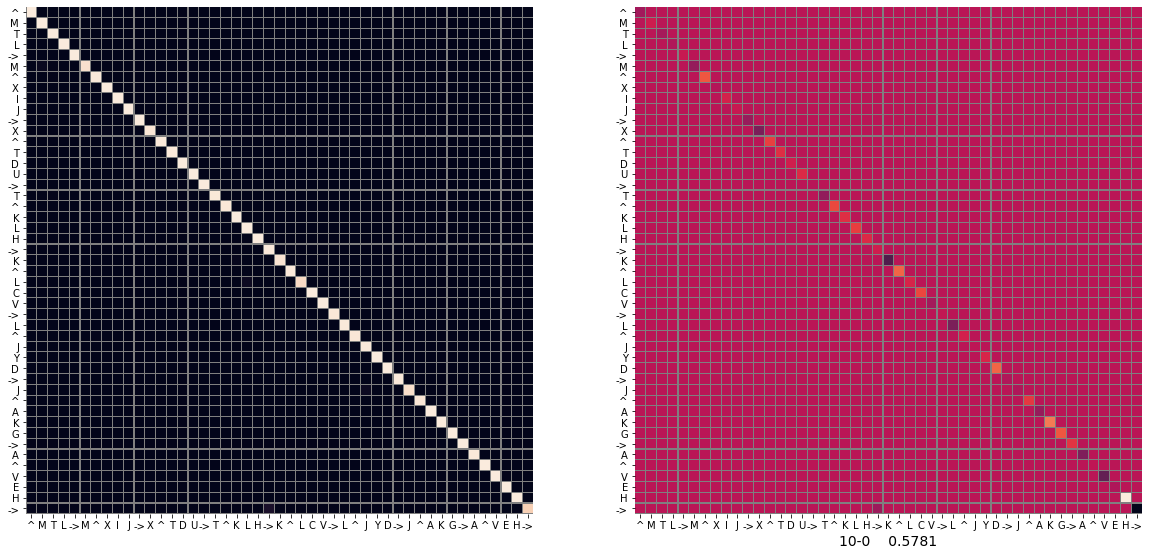

In [259]:
for i in range(len(top_heads)):
    layer, head, v, _ = top_heads[i]
    if layer in [0, 1, ]: continue
#     layer, head, v = 30, 10, 1.
    fig, axs = plt.subplots(1,2,sharey=False, figsize=(10 * 2, 10))
    for i, (a, _ax) in enumerate(zip([attns, attrs], axs)):
        a = a[layer][head].detach().cpu()
        a, annot = ((a * 100).long(), True) if i == -1 else (a, False)
        res = sns.heatmap(a, square=True, cbar=False, annot=annot, fmt='d', linewidths=0.1, linecolor='grey', 
                          xticklabels=tokens, yticklabels=tokens, ax=_ax)
        _ = res.set_xticklabels(res.get_xmajorticklabels(), fontsize=9+3-2, rotation=0)
        _ = res.set_yticklabels(res.get_ymajorticklabels(), fontsize=9+3-2, rotation=0)
        _ = plt.xlabel('%d-%d    %.4f' % (layer, head, v), fontsize=14)

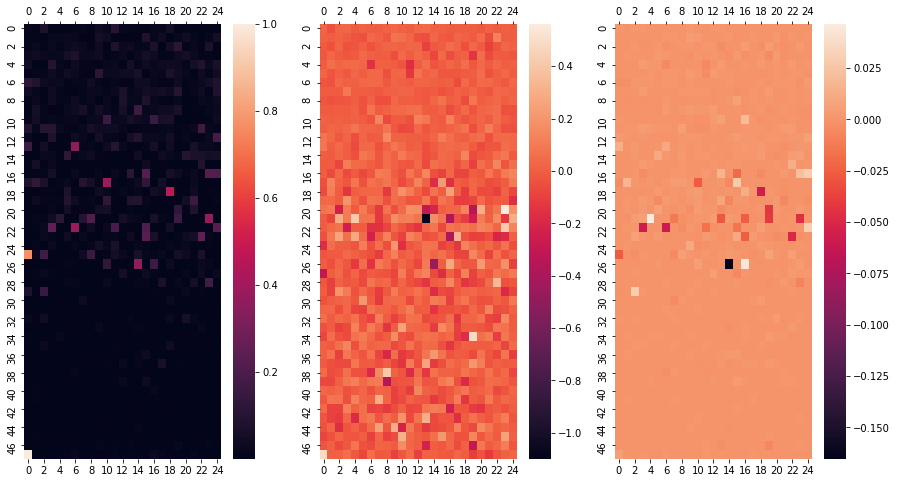

In [555]:
n_rows, n_cols = 1, 3
fig, axs = plt.subplots(n_rows, n_cols, sharey=False, figsize=(5 * n_cols, 2 * 4 * n_rows))
A = [attns, grads, attrs]

for row in range(n_rows):
    for col in range(n_cols):
        ax = axs[row][col] if row > 1 else axs[col]
        a = A[col][:, :, src,tgt].detach()
        if col == 0: a[-1, 0] = 1.
#         fig = plt.subplots(1,1,sharey=False, figsize=(5 , 8))
        ax = sns.heatmap(a, ax=ax)
        ax.tick_params(top=True, labeltop=True)

In [383]:
logits = outputs.logits if hasattr(outputs, 'logits') else outputs[0]
values, indices = logits[0, -1].softmax(dim=-1).topk(5)
list(zip(tokenizer.convert_ids_to_tokens(indices), values.tolist()))

In [132]:
input_ids = tokenizer.encode_plus(_text)['input_ids']
print(tokenizer.convert_ids_to_tokens(input_ids))
outputs = model.generate(torch.LongTensor([input_ids]).to(model.device))
print(_text, tokenizer.decode(outputs[0]))

input_ids = input_ids[: -3] + input_ids[-2:]
print(tokenizer.convert_ids_to_tokens(input_ids))
outputs = model.generate(torch.LongTensor([input_ids]).to(model.device))
print(_text, tokenizer.decode(outputs[0]))

['▁Big', '▁and', '▁small', '▁are', '<extra_id_0>', '▁', '.', '</s>']
Big and small are <extra_id_0> . <pad> <extra_id_0> welcome<extra_id_1>.</s>
['▁Big', '▁and', '▁small', '▁are', '<extra_id_0>', '.', '</s>']
Big and small are <extra_id_0> . <pad> <extra_id_0> welcome<extra_id_1> welcome.</s>


In [342]:
texts = [
    'Big is to small as fast is to _',
    'Bread is to eat as gun is to _',
    'big: small, fast: _',
    'bread: eat, gun: _ .',
    'flower: fragrant, fire: hot, bread: delicious, gun: _ ',
    'Big and small are _ .',
    'What is twice 3? _.',
    'What is the half 6? _.',
    'There is a sequence: 3, 5, 2, 7. The number immediately precedes 5 is _.',  # :)
    'There is a sequence: 3, 5, 2, 7. The number immediately follows 5 is _.',  # :(
    'There is a sequence: 3, 5, 2, 7. The number between 5 and 7 is _.',
    'There is a sequence of numbers: 3, 5, 2, 4. _ is the first number.',
    'There is a sequence of numbers: 3, 5, 2. The reversed sequence is _.',
    '''There is a sequence of numbers: 5, 1, 6, 3. The second number is 1.
There is a sequence of numbers: 3, 7, 2, 4. The second number is _.''',
    '''There is a sequence of letters: e, c, b, a. The last letter is a.
There is a sequence of letters: f, d, b, g. The last letter is _.''',
    '''The uppercase of c is C. The uppercase of f is _.''',
    '''The successor of 3 is 4. The successor of 8 is _.''',
    '''The successor of 3 is 4. The successor of _ is 6.''',
#     '''The predecessor of 3 is 2. The predecessor of 5 is 4. The predecessor of 6 is _''',
#     '''The previous integer of 4 is 3. The previous integer of 3 is _.''',
#     '''3 minus 1 equals 2. 5 minus 1 equals _.''',
    '''If 2 changes to 3, 5 changes to 6, then _ changes to 9''',
    '''If 2 changes to 20, 3 changes to 30, then 5 changes to _''',
    '''2 -> 3, 4 -> 5, 5 -> 6, 9 -> _.''',
    '''3 -> 2, 5 -> 4, 6 -> 5, 9 -> _''',
    '''9 -> 8, 7 -> 6, 6 -> 5, 2 -> _.''',
    '''3 is to _ as 4 is to 8 and 5 is to 10.''',
#     '''6 : _ :: 5 : 10 :: 7 : 14 :: 8 : 16.''',
#     '''a is to _ as f is to g, h to i, i to j, s to t.''',
#     '''c is to _ as f is to e, h to g, j to i.''',
    '''c is to _ as j is to i, h to g, f to e.''',
#     '''Twice 3 is 6, twice 4 is _.''',
#     '''Half of 4 is 2, half of 6 is _.''',

# '''Shall I compare thee to a summer's day?
# Thou''',
# '''Do not go gentle into that good night,
# Old age should burn and rave at close of day;
# Rage'''
]